In [2]:
using Interpolations
using Distributed
using DataFrames
using Printf
using JLD
using CSV
using Dierckx
using Dates
using PyPlot
# using PyCall
using Seaborn
using LaTeXStrings

main_path = "/home/artur/BondPricing"
module_path = string(main_path, "/", "Julia/modules/")
modls = ["Batch", "ModelObj", 
         "AnalyticFunctions", "BondPrInterp",
         "EqFinDiff", "FullInfoEq",
         "ModelPlots", "JointEq"]
for modl in modls
    include(string(joinpath(module_path, modl), ".jl"))
end
# for modl in modls
#     include(string(joinpath(module_path, modl), "/", modl, ".jl"))
# end
# # modl = "ModelPlots"

ENV["LINES"] = 750
ENV["COLUMNS"] = 10000

┌ Info: Recompiling stale cache file /home/artur/.julia/compiled/v1.2/DSP/OtML7.ji for DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/artur/.julia/compiled/v1.2/ModelObj.ji for ModelObj [top-level]
└ @ Base loading.jl:1240
┌ Warning: Module CSV with build ID 3656653319895276 is missing from the cache.
│ This may mean CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing ModelObj [top-level].
└ @ Base loading.jl:1017
┌ Info: Recompiling stale cache file /home/artur/.julia/compiled/v1.2/AnalyticFunctions.ji for AnalyticFunctions [top-level]
└ @ Base loading.jl:1240
┌ Warning: Module ModelObj with build ID 343019454318247 is missing from the cache.
│ This may mean ModelObj [top-level] does not support precompilation but is imported by a module that does.
└ @ Base loading.j

Figure(PyObject <Figure size 400x100 with 1 Axes>)

┌ Warning: Module CSV with build ID 3656653319895276 is missing from the cache.
│ This may mean CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing FullInfoEq [top-level].
└ @ Base loading.jl:1017


10000

In [3]:
for modl in modls
    include(string(joinpath(module_path, modl), ".jl"))
end

Figure(PyObject <Figure size 400x100 with 1 Axes>)

In [ ]:
# INPUTS ###################################################
# Measure of Safe Firms
mu_s = .2

# Transaction Costs and Volatility Risk Parameters
cvmdict = Dict{Symbol,Array{Float64,1}}(:sigmal => [0.15],
                                        :m  => [1.],
                                        :gross_delta => [0.02],
                                        :kappa  => [25 * 1e-4],
                                        :mu_b => [1.0],
                                        :xi => [1.0],
                                        :iota => [x for x in Batch.cvm_param_values_dict[:iota] 
                                                  if x <= 20. * 1e-4])
svmdict = deepcopy(cvmdict)
svmdict[:lambda] = [.2]
svmdict[:iota] = [.0]
svmdict[:sigmah] = Batch.svm_param_values_dict[:sigmah]
# #########################################################


# Get Safe and Risky Firms' Full Info Optimal Results #####
firm_obj_fun = :firm_value 
cvmdf, svmdf, _ = ModelPlots.get_cvm_svm_dfs(cvmdict, svmdict;
                                             firm_obj_fun=firm_obj_fun)
# #########################################################
                
# Form Safe Type
sf_model = "cvm"
sf_iota = 5 * 1e-4
sf_df = (sf_model == "cvm") ? cvmdf : svmdf
sf_comb_num = sf_df[abs.(sf_df[:, :iota] .- sf_iota) .< 1e-5, :comb_num][1]
sf_bt, sf = Batch.get_bt_mobj(; model=sf_model, comb_num=sf_comb_num)
sf = ModelObj.set_opt_k_struct(sf, sf_df)

In [139]:
# Risky Type's - Hedging Firm ##########################################
rfh_model = "cvm"
rfh_iota = 5 * 1e-4
rfh_df = (sf_model == "cvm") ? cvmdf : svmdf
rfh_comb_num = sf_df[abs.(sf_df[:, :iota] .- sf_iota) .< 1e-5, :comb_num][1]
rfh_bt, rfh = Batch.get_bt_mobj(; model=rfh_model, comb_num=rfh_comb_num)
rfh = ModelObj.set_opt_k_struct(rfh, rfh_df)
# #########################################################


# Risky Type's - Volatility Risk Firm #########################################
rfv_model = "cvm"

cn = 12
if cn + 1 <= size(cvmdf, 1)
    rfv_comb_num = cvmdf[cn + 1, :comb_num]
    rfv_bt, rfv = Batch.get_bt_cvm(; comb_num=rfv_comb_num)
    rfv = ModelObj.set_opt_k_struct(rfv, cvmdf)

    println(string("rf iota: ", rfv.pm.iota))  
else #cn > size(cvmdf, 1)
    svm_row = cn + 1 - size(cvmdf, 1)
    rfv_comb_num = svmdf[svm_row, :comb_num]
    rfv_bt, rfv = Batch.get_bt_svm(; comb_num=rfv_comb_num)
    rfv = ModelObj.set_opt_k_struct(rfv, svmdf)
end
# #########################################################

Setting parameter dictionary using unique combination ID...
Setting initial vbl value to NaN
Setting initial vbh value to NaN
Setting initial c value to NaN
Setting initial p value to NaN
Constant Volatility Model: setting vbh to vbl, lambda to NaN
Setting parameter dictionary using unique combination ID...
Loading SVM object...
Batch object file not found.
Batch Object is incompatible! Loading surfaces only instead.
Setting initial vbl value to NaN
Setting initial vbh value to NaN
Setting initial c value to NaN
Setting initial p value to NaN
Interpolating Bond Pricing Surfaces...
  0.206892 seconds (811.45 k allocations: 137.114 MiB, 11.72% gc time)
Batch object exists: true
Interpolating bond pricing surfaces...
  0.200143 seconds (811.45 k allocations: 137.112 MiB, 12.16% gc time)


ModelObj.Firm
  mu_b: Float64 1.0
  m: Float64 1.0
  c: Float64 NaN
  p: Float64 NaN
  vbl: Float64 NaN
  vbh: Float64 NaN
  pm: ModelObj.FirmParams
  model: String "svm"
  bi: ModelObj.BPrInputs
  bs: ModelObj.BPrSurfs
  bf: ModelObj.BPrInterpFuns
  bit: ModelObj.BPrFixedTTMInputs
  bft: ModelObj.BPrInterpFuns
  optKS: ModelObj.KStruct


In [140]:


# #########################################################
# Optimal p/c Ratio: sf.optKS.p/sf.optKS.c ~~ 12
ep_c = JointEq.round_value(sf.optKS.c)
ep_ratio = JointEq.round_value(sf.optKS.p/sf.optKS.c)
ep_p = ep_ratio * ep_c

# Pick Capital Structure
jks = JointEq.JointKStruct(mu_s, 
                           sf.optKS.mu_b,
                           sf.optKS.m, ep_c, ep_p, 
                           NaN, NaN, NaN, NaN, NaN)

# Joint Firm Object
jf = JointEq.JointFirms(jks, rfh, rfv,
                        rfh_bt,
                        rfv_bt,  
                        cvmdf, svmdf)
# #########################################################

Main.JointEq.JointFirms(Main.JointEq.JointKStruct(0.2, 1.0, 1.0, 4.5, 54.0, NaN, NaN, NaN, NaN, NaN), ModelObj.Firm
  mu_b: Float64 1.0
  m: Float64 1.0
  c: Float64 NaN
  p: Float64 NaN
  vbl: Float64 NaN
  vbh: Float64 NaN
  pm: ModelObj.FirmParams
  model: String "cvm"
  bi: ModelObj.BPrInputs
  bs: ModelObj.BPrSurfs
  bf: ModelObj.BPrInterpFuns
  bit: ModelObj.BPrFixedTTMInputs
  bft: ModelObj.BPrInterpFuns
  optKS: ModelObj.KStruct
, ModelObj.Firm
  mu_b: Float64 1.0
  m: Float64 1.0
  c: Float64 NaN
  p: Float64 NaN
  vbl: Float64 NaN
  vbh: Float64 NaN
  pm: ModelObj.FirmParams
  model: String "svm"
  bi: ModelObj.BPrInputs
  bs: ModelObj.BPrSurfs
  bf: ModelObj.BPrInterpFuns
  bit: ModelObj.BPrFixedTTMInputs
  bft: ModelObj.BPrInterpFuns
  optKS: ModelObj.KStruct
, Main.Batch.BatchStruct
  model: String "cvm"
  dfn: Main.Batch.DirFileNames
  dfc: Main.Batch.BatchDFColumns
  mi: Main.Batch.ModelInputs
  bp: Main.Batch.BatchParams
  coupon_grid: Array{Float64}((52,)) [0.25, 0.5, 

In [141]:
# =JointKStruct(fill(NaN, 10)...),
function tmp_fun(svm;
                                   mu_b_min::Float64=.5,
                                   mu_b_max::Float64=5.,
                                   mu_bN::Int64=20,
                                   mu_bN2::Int64=10^5,
                                   jks,
                                   m::Float64=NaN,
                                   c::Float64=NaN,
                                   p::Float64=NaN,
                                   lb::Float64=.75,
                                   ub::Float64=1.25,
                                   vbN::Int64=15,
                                   vbN2::Int64=10^5,
                                   spline_k::Int64=3,
                                   spline_bc::String="extrapolate",
                                   tol::Float64=2.5 * 1e-3)

    # Set Capital Structure #########################
    if !isnan(m)
        setfield!(jks, :m, m)
    elseif isnan(jks.m)
        setfield!(jks, :m, jf.jks.m)
    end
    
    if !isnan(c)
        setfield!(jks, :c, c)
    elseif isnan(jks.c)
        setfield!(jks, :c, jf.jks.c)
    end

    if !isnan(p)
        setfield!(jks, :p, p)
    elseif isnan(jks.p)
        setfield!(jks, :p, jf.jks.p)
    end
    # ###############################################

    
    # Get Optimal VB for each mu_b value ############
    tmp = FullInfoEq.form_mu_b_vb_pairs(svm, jks;
                             mu_b_min=mu_b_min,
                             mu_b_max=mu_b_max,
                             mu_bN=mu_bN, mu_bN2=mu_bN2,
                             lb=lb, ub=ub,
                             vbN=vbN, vbN2=vbN2)
    # ###############################################

    
    # Run Equity Finite Differences Method ##########
    res = fetch(@spawn [EqFinDiff.eq_fd(svm; vbl=tmp[r, :vbl],
                              mu_b=tmp[r, :mu_b],
                              m=jks.m, c=jks.c, p=jks.p)
                        for r in 1:size(tmp, 1)])
    df = vcat(res...)
    # ###############################################

end

tmp_fun (generic function with 1 method)

In [142]:
sfmubdf = tmp_fun(jf.sf; jks=jf.jks)

COUNT: 0
COUNT: 1
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9749999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: NaN
eq_abs_per_diff: NaN
Equity Vmax: 131.25
 
eq_max: 107.70368999486152
eq_vbl: 0.0
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 77.22935583862443
Equity Core Function Computation Time: 0.062484025955200195
Total Equity FD Core Function Computation Time: 0.10849714279174805
Total computation time: 0.11457705497741699
Computing Equity Vmax
Vmax: 125.0
phi0: -23.049856754763113
phi1: 0.9749999999999998
pv_rfdebt: 30.72847226680701
debt_abs_per_diff: NaN
eq_abs_per_diff: NaN
Equity Vmax: 131.25
 
eq_max: 104.91005816390219
eq_vbl: 0.0
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 74.42822113020445
Equity Core Function Computation Time: 0.03320002555847168
Total Equity FD Core Function Computation Time: 0.1918790340423584
Total computation time: 0.19771599769592285
Computing

Computing equity values... 
V0: 100.0; equity: 1.2984180000627914
Equity Core Function Computation Time: 0.0358738899230957
Total Equity FD Core Function Computation Time: 0.06890392303466797
Total computation time: 0.07450199127197266
Computing Equity Vmax
Vmax: 125.0
phi0: -70.45550870994339
phi1: 0.9749999999999998
pv_rfdebt: 93.92640346842474
debt_abs_per_diff: NaN
eq_abs_per_diff: NaN
Equity Vmax: 131.25
 
eq_max: 43.79888437850591
eq_vbl: 0.0
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15764689445495605
Total Equity FD Core Function Computation Time: 0.21970009803771973
Total computation time: 0.22524785995483398
Computing Equity Vmax
Vmax: 125.0
phi0: -73.24407647201282
phi1: 0.9749999999999998
pv_rfdebt: 97.64392883322579
debt_abs_per_diff: NaN
eq_abs_per_diff: NaN
Equity Vmax: 131.25
 
eq_max: 37.40595016566879
eq_vbl: 0.0
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity:

,MBR,V0,alpha,c,debt,delta,eq_deriv,eq_deriv_min_val,eq_min_val,eq_negative,eq_vb,equity,firm_value,gross_delta,iota,kappa,lambda,leverage,m,mu_b,p,pi,r,sigmah,sigmal,vb,xi
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5.80951,100.0,0.6,4.5,27.0109,0.0195,2.52928,0.975054,0.0738039,0,0.0,77.2294,104.24,0.02,0.0005,0.0025,NaN,25.9122,1.0,0.5,54.0,0.27,0.08,NaN,0.15,29.0457,1.0
2,7.44418,100.0,0.6,4.5,30.7285,0.0195,2.52918,0.975126,0.0767902,0,0.0,74.4282,105.157,0.02,0.0005,0.0025,NaN,29.2216,1.0,0.568815,54.0,0.27,0.08,NaN,0.15,33.0433,1.0
3,9.24578,100.0,0.6,4.5,34.446,0.0195,2.52898,0.975268,0.0789556,0,0.0,71.615,106.061,0.02,0.0005,0.0025,NaN,32.4775,1.0,0.63763,54.0,0.27,0.08,NaN,0.15,37.0409,1.0
4,11.1051,100.0,0.6,4.5,38.1635,0.0195,0.000224155,0.000224155,0.000408113,0,0.0,68.7035,106.867,0.02,0.0005,0.0025,NaN,35.7112,1.0,0.706445,54.0,0.27,0.08,NaN,0.15,41.0385,1.0
5,13.1667,100.0,0.6,4.5,41.8811,0.0195,0.00022228,0.00022228,0.000379722,0,0.0,65.7713,107.652,0.02,0.0005,0.0025,NaN,38.904,1.0,0.775261,54.0,0.27,0.08,NaN,0.15,45.036,1.0
6,15.3404,100.0,0.6,4.5,45.5986,0.0195,0.00022063,0.00022063,0.000350895,0,0.0,62.7468,108.345,0.02,0.0005,0.0025,NaN,42.0863,1.0,0.844076,54.0,0.27,0.08,NaN,0.15,49.0336,1.0
7,17.5642,100.0,0.6,4.5,49.3161,0.0195,0.000219156,0.000219156,0.000322073,0,0.0,59.5861,108.902,0.02,0.0005,0.0025,NaN,45.2848,1.0,0.912891,54.0,0.27,0.08,NaN,0.15,53.0312,1.0
8,19.7244,100.0,0.6,4.5,53.0335,0.0195,0.000217818,0.000217818,0.000293597,0,0.0,56.2303,109.264,0.02,0.0005,0.0025,NaN,48.5371,1.0,0.981706,54.0,0.27,0.08,NaN,0.15,57.0287,1.0
9,21.6259,100.0,0.6,4.5,56.7503,0.0195,0.000216581,0.000216581,0.000265741,0,0.0,52.6028,109.353,0.02,0.0005,0.0025,NaN,51.8964,1.0,1.05052,54.0,0.27,0.08,NaN,0.15,61.0263,1.0


In [143]:
rfmubdf = tmp_fun(jf.rf; jks=jf.jks)

COUNT: 0
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 0.0008255911014374627
eq_abs_per_diff: 0.0009258340689315004
Equity Vmax: 184.6819304736329
 
eq_max: 164.42011330616214
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008165121078491211
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 79.29731015797866
Equity Core Function Computation Time: 0.03261089324951172
Total Equity FD Core Function Computation Time: 0.07286715507507324
Total computation time: 0.09405398368835449
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 0.0008255911014374627
eq_abs_per_diff: 0.0009258340689315004
Equity Vmax: 184.6819304736329
 
eq_max: 164.4201133061621
eq_vbl: 0.0
Computing Constant V

debt_abs_per_diff: 0.0008255911014374627
eq_abs_per_diff: 0.0009258340689315004
Equity Vmax: 184.6819304736329
 
eq_max: 164.42011330616216
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008297920227050781
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 79.29871088020147
Equity Core Function Computation Time: 0.03542280197143555
Total Equity FD Core Function Computation Time: 0.07660794258117676
Total computation time: 0.09479713439941406
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 0.0008255911014374627
eq_abs_per_diff: 0.0009258340689315004
Equity Vmax: 184.6819304736329
 
eq_max: 164.42011330616214
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Val

V0: 100.0; equity: 68.1122509931174
Equity Core Function Computation Time: 0.03545784950256348
Total Equity FD Core Function Computation Time: 0.07640814781188965
Total computation time: 0.10476398468017578
Computing Equity Vmax
Vmax: 125.0
phi0: -29.858741673443316
phi1: 0.9999999999999998
pv_rfdebt: 39.8056059608509
debt_abs_per_diff: 1.9679545783279525e-7
eq_abs_per_diff: 0.000917088672933059
Equity Vmax: 272.8593235477421
 
eq_max: 242.99981457742751
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008269071578979492
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 68.11451260694012
Equity Core Function Computation Time: 0.03271913528442383
Total Equity FD Core Function Computation Time: 0.07652091979980469
Total computation time: 0.10491299629211426
Computing Equity Vmax
Vmax: 125.0
phi0: -29.858741673443316
phi1: 0.9999999999999998
pv_rfd

V0: 100.0; equity: 55.400934941869316
Equity Core Function Computation Time: 0.035531044006347656
Total Equity FD Core Function Computation Time: 0.07657599449157715
Total computation time: 0.11255502700805664
Computing Equity Vmax
Vmax: 125.0
phi0: -39.45619435419297
phi1: 0.9999999999999998
pv_rfdebt: 52.60026501969583
debt_abs_per_diff: 4.000129228594848e-8
eq_abs_per_diff: 0.0008705532362083225
Equity Vmax: 365.65758999021574
 
eq_max: 326.2004583425686
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008238077163696289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 55.3348809858868
Equity Core Function Computation Time: 0.032961130142211914
Total Equity FD Core Function Computation Time: 0.07657599449157715
Total computation time: 0.11263608932495117
Computing Equity Vmax
Vmax: 125.0
phi0: -39.45619435419297
phi1: 0.9999999999999998
pv_r

V0: 100.0; equity: 40.52533008070124
Equity Core Function Computation Time: 0.03796100616455078
Total Equity FD Core Function Computation Time: 0.08145308494567871
Total computation time: 0.12256193161010742
Computing Equity Vmax
Vmax: 125.0
phi0: -49.0536470349426
phi1: 0.9999999999999998
pv_rfdebt: 65.39492407854075
debt_abs_per_diff: 3.997792228427817e-8
eq_abs_per_diff: 0.0009466251740325797
Equity Vmax: 444.4590859930447
 
eq_max: 395.4041166551884
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008188009262084961
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 40.26396116846309
Equity Core Function Computation Time: 0.15828204154968262
Total Equity FD Core Function Computation Time: 0.2251269817352295
Total computation time: 0.26621294021606445
Computing Equity Vmax
Vmax: 125.0
phi0: -49.0536470349426
phi1: 0.9999999999999998
pv_rfdebt:

V0: 100.0; equity: 24.851351272369282
Equity Core Function Computation Time: 0.03762507438659668
Total Equity FD Core Function Computation Time: 0.08112692832946777
Total computation time: 0.1272118091583252
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt: 78.1895831373857
debt_abs_per_diff: 3.99779597126562e-8
eq_abs_per_diff: 0.00089046918602131
Equity Vmax: 540.2427968938333
 
eq_max: 481.59025551363254
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008162975311279297
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 24.172698733883962
Equity Core Function Computation Time: 0.15687990188598633
Total Equity FD Core Function Computation Time: 0.22353482246398926
Total computation time: 0.26975107192993164
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt

V0: 100.0; equity: 4.348118548917887
Equity Core Function Computation Time: 0.037953853607177734
Total Equity FD Core Function Computation Time: 0.0822751522064209
Total computation time: 0.1285688877105713
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt: 78.1895831373857
debt_abs_per_diff: 3.99779597126562e-8
eq_abs_per_diff: 0.00089046918602131
Equity Vmax: 540.2427968938333
 
eq_max: 481.5902555136326
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008332014083862305
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.1684589385986328
Total Equity FD Core Function Computation Time: 0.23649907112121582
Total computation time: 0.28276896476745605
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt: 78.1895831373857

V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03806710243225098
Total Equity FD Core Function Computation Time: 0.08335089683532715
Total computation time: 0.13350987434387207
Computing Equity Vmax
Vmax: 125.0
phi0: -68.24855239644188
phi1: 0.9999999999999998
pv_rfdebt: 90.98424219623061
debt_abs_per_diff: 3.997795959338363e-8
eq_abs_per_diff: 0.0009077576409503707
Equity Vmax: 625.3985677542238
 
eq_max: 557.148288391407
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008272886276245117
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.1630699634552002
Total Equity FD Core Function Computation Time: 0.23175883293151855
Total computation time: 0.2818949222564697
Computing Equity Vmax
Vmax: 125.0
phi0: -68.24855239644188
phi1: 0.9999999999999998
pv_rfdebt: 90.98424219623061
debt_abs_

V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.037856101989746094
Total Equity FD Core Function Computation Time: 0.0806429386138916
Total computation time: 0.13439083099365234
Computing Equity Vmax
Vmax: 125.0
phi0: -77.84600507719152
phi1: 0.9999999999999998
pv_rfdebt: 103.77890125507555
debt_abs_per_diff: 3.997795964045467e-8
eq_abs_per_diff: 0.0008592524790068457
Equity Vmax: 723.9770169964834
 
eq_max: 646.1291987845578
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008238077163696289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15653586387634277
Total Equity FD Core Function Computation Time: 0.22242307662963867
Total computation time: 0.2762939929962158
Computing Equity Vmax
Vmax: 125.0
phi0: -77.84600507719152
phi1: 0.9999999999999998
pv_rfdebt: 103.77890125507555
debt_

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.039340972900390625
Total Equity FD Core Function Computation Time: 0.0830068588256836
Total computation time: 0.13927817344665527
Computing Equity Vmax
Vmax: 125.0
phi0: -87.44345775794116
phi1: 0.9999999999999998
pv_rfdebt: 116.57356031392048
debt_abs_per_diff: 3.997795979909766e-8
eq_abs_per_diff: 0.0009209488275577129
Equity Vmax: 798.184661238623
 
eq_max: 710.738942111485
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008346080780029297
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15784788131713867
Total Equity FD Core Function Computation Time: 0.2244400978088379
Total computation time: 0.28078603744506836
Computing Equity Vmax
Vmax: 125.0
phi0: -87.44345775794116
phi1: 0.9999999999999998
pv_rfdebt

debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.0009436615074900405
Equity Vmax: 879.998589015582
 
eq_max: 782.9550750596426
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008159160614013672
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15901398658752441
Total Equity FD Core Function Computation Time: 0.22600007057189941
Total computation time: 0.28491711616516113
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfdebt: 129.36821937276542
debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.0009436615074900405
Equity Vmax: 879.998589015582
 
eq_max: 782.9550750596431
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0081789493560

debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.0009436615074900405
Equity Vmax: 879.998589015582
 
eq_max: 782.955075059643
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008318185806274414
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.16824698448181152
Total Equity FD Core Function Computation Time: 0.23409700393676758
Total computation time: 0.29349803924560547
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfdebt: 129.36821937276542
debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.0009436615074900405
Equity Vmax: 879.998589015582
 
eq_max: 782.955075059643
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008419036865234

debt_abs_per_diff: 3.997795973083107e-8
eq_abs_per_diff: 0.0009322710231663244
Equity Vmax: 970.1984443896793
 
eq_max: 863.5572721945225
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008275032043457031
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.1594829559326172
Total Equity FD Core Function Computation Time: 0.2258741855621338
Total computation time: 0.2877779006958008
Computing Equity Vmax
Vmax: 125.0
phi0: -106.63836311944044
phi1: 0.9999999999999998
pv_rfdebt: 142.16287843161035
debt_abs_per_diff: 3.997795973083107e-8
eq_abs_per_diff: 0.0009322710231663244
Equity Vmax: 970.1984443896793
 
eq_max: 863.5572721945225
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00827407836914

debt_abs_per_diff: 3.997795956759073e-8
eq_abs_per_diff: 0.0008936230787704929
Equity Vmax: 1069.6437849396214
 
eq_max: 953.4050967364683
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008244991302490234
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15793704986572266
Total Equity FD Core Function Computation Time: 0.22432398796081543
Total computation time: 0.28864598274230957
Computing Equity Vmax
Vmax: 125.0
phi0: -116.23581580019007
phi1: 0.9999999999999998
pv_rfdebt: 154.95753749045528
debt_abs_per_diff: 3.997795956759073e-8
eq_abs_per_diff: 0.0008936230787704929
Equity Vmax: 1069.6437849396214
 
eq_max: 953.4050967364684
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008255004

debt_abs_per_diff: 3.997795959867821e-8
eq_abs_per_diff: 0.0008351238925552807
Equity Vmax: 1179.2822728959327
 
eq_max: 1053.4461969711801
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008198022842407227
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15605497360229492
Total Equity FD Core Function Computation Time: 0.22192096710205078
Total computation time: 0.2887551784515381
Computing Equity Vmax
Vmax: 125.0
phi0: -125.8332684809397
phi1: 0.9999999999999998
pv_rfdebt: 167.7521965493002
debt_abs_per_diff: 3.997795959867821e-8
eq_abs_per_diff: 0.0008351238925552807
Equity Vmax: 1179.2822728959327
 
eq_max: 1053.4461969711801
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0082190036

debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.0009153450203220979
Equity Vmax: 1238.2463865407294
 
eq_max: 1102.8121951184824
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008173942565917969
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15804696083068848
Total Equity FD Core Function Computation Time: 0.22445297241210938
Total computation time: 0.29261207580566406
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv_rfdebt: 180.54685560814514
debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.0009153450203220979
Equity Vmax: 1238.2463865407294
 
eq_max: 1102.8121951184824
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0081729

debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.0009153450203220979
Equity Vmax: 1238.2463865407294
 
eq_max: 1102.8121951184824
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00830984115600586
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.158203125
Total Equity FD Core Function Computation Time: 0.2260279655456543
Total computation time: 0.29477787017822266
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv_rfdebt: 180.54685560814514
debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.0009153450203220979
Equity Vmax: 1238.2463865407294
 
eq_max: 1102.8121951184824
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00832390785217285

debt_abs_per_diff: 3.9977959648509606e-8
eq_abs_per_diff: 0.0009847578075136306
Equity Vmax: 1300.158705867766
 
eq_max: 1155.126382710736
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008275985717773438
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.156998872756958
Total Equity FD Core Function Computation Time: 0.22453904151916504
Total computation time: 0.294370174407959
Computing Equity Vmax
Vmax: 125.0
phi0: -145.028173842439
phi1: 0.9999999999999998
pv_rfdebt: 193.34151466699007
debt_abs_per_diff: 3.9977959648509606e-8
eq_abs_per_diff: 0.0009847578075136306
Equity Vmax: 1300.158705867766
 
eq_max: 1155.126382710736
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008285999298095

debt_abs_per_diff: 3.9977959668785834e-8
eq_abs_per_diff: 0.0008695561985896653
Equity Vmax: 1433.424973219212
 
eq_max: 1278.7956798676876
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008235931396484375
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15703988075256348
Total Equity FD Core Function Computation Time: 0.2228529453277588
Total computation time: 0.29520606994628906
Computing Equity Vmax
Vmax: 125.0
phi0: -154.62562652318863
phi1: 0.9999999999999998
pv_rfdebt: 206.136173725835
debt_abs_per_diff: 3.9977959668785834e-8
eq_abs_per_diff: 0.0008695561985896653
Equity Vmax: 1433.424973219212
 
eq_max: 1278.7956798676878
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0082578659

debt_abs_per_diff: 3.9977959686692104e-8
eq_abs_per_diff: 0.0009072406428347676
Equity Vmax: 1505.0962218801726
 
eq_max: 1340.8689907340995
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008204936981201172
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15926289558410645
Total Equity FD Core Function Computation Time: 0.2264420986175537
Total computation time: 0.2999739646911621
Computing Equity Vmax
Vmax: 125.0
phi0: -164.22307920393825
phi1: 0.9999999999999998
pv_rfdebt: 218.93083278467992
debt_abs_per_diff: 3.9977959686692104e-8
eq_abs_per_diff: 0.0009072406428347676
Equity Vmax: 1505.0962218801726
 
eq_max: 1340.8689907340995
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0082080

debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0009346228003211545
Equity Vmax: 1580.3510329741814
 
eq_max: 1406.5259048605958
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00816202163696289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15780091285705566
Total Equity FD Core Function Computation Time: 0.22420215606689453
Total computation time: 0.2989170551300049
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_rfdebt: 231.72549184352488
debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0009346228003211545
Equity Vmax: 1580.3510329741814
 
eq_max: 1406.5259048605953
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0081770420

debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0009346228003211545
Equity Vmax: 1580.3510329741814
 
eq_max: 1406.5259048605956
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008311986923217773
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.16187405586242676
Total Equity FD Core Function Computation Time: 0.2293848991394043
Total computation time: 0.3045468330383301
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_rfdebt: 231.72549184352488
debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0009346228003211545
Equity Vmax: 1580.3510329741814
 
eq_max: 1406.5259048605956
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0083200931

debt_abs_per_diff: 3.997795971688292e-8
eq_abs_per_diff: 0.0009519803355074256
Equity Vmax: 1659.3685846228905
 
eq_max: 1475.9456135473533
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008272171020507812
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15758109092712402
Total Equity FD Core Function Computation Time: 0.22442293167114258
Total computation time: 0.3005940914154053
Computing Equity Vmax
Vmax: 125.0
phi0: -183.41798456543754
phi1: 0.9999999999999998
pv_rfdebt: 244.52015090236978
debt_abs_per_diff: 3.997795971688292e-8
eq_abs_per_diff: 0.0009519803355074256
Equity Vmax: 1659.3685846228905
 
eq_max: 1475.9456135473533
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00828504

debt_abs_per_diff: 3.997795972972652e-8
eq_abs_per_diff: 0.000959836634897767
Equity Vmax: 1742.3370138540351
 
eq_max: 1549.316263728428
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008256912231445312
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.15737104415893555
Total Equity FD Core Function Computation Time: 0.2248220443725586
Total computation time: 0.30223894119262695
Computing Equity Vmax
Vmax: 125.0
phi0: -193.0154372461872
phi1: 0.9999999999999998
pv_rfdebt: 257.31480996121473
debt_abs_per_diff: 3.997795972972652e-8
eq_abs_per_diff: 0.000959836634897767
Equity Vmax: 1742.3370138540351
 
eq_max: 1549.3162637284277
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008245944976

debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0009588988511525884
Equity Vmax: 1829.453864546737
 
eq_max: 1626.8354057795345
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008188962936401367
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.1571512222290039
Total Equity FD Core Function Computation Time: 0.2230989933013916
Total computation time: 0.3018147945404053
Computing Equity Vmax
Vmax: 125.0
phi0: -202.61288992693682
phi1: 0.9999999999999998
pv_rfdebt: 270.10946902005963
debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0009588988511525884
Equity Vmax: 1829.453864546737
 
eq_max: 1626.8354057795345
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008203983306

V0: 100.0; equity: 79.29586599556303
Equity Core Function Computation Time: 0.03632211685180664
Total Equity FD Core Function Computation Time: 0.07763504981994629
Total computation time: 0.09509801864624023
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 0.0008255911014374627
eq_abs_per_diff: 0.0009258340689315004
Equity Vmax: 184.6819304736329
 
eq_max: 164.42011330616214
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008177042007446289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 79.3009098961013
Equity Core Function Computation Time: 0.1565849781036377
Total Equity FD Core Function Computation Time: 0.2262887954711914
Total computation time: 0.24383306503295898
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rf

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008477926254272461
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 79.29778836632728
Equity Core Function Computation Time: 0.03566694259643555
Total Equity FD Core Function Computation Time: 0.0775001049041748
Total computation time: 0.0956268310546875
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 0.0008255911014374627
eq_abs_per_diff: 0.0009258340689315004
Equity Vmax: 184.6819304736329
 
eq_max: 164.42011330616214
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008315086364746094
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 79.29655651256905
Equity Core Function Computation Time: 0.1570451259613037
Total Equity FD 

debt_abs_per_diff: 4.928105586331847e-5
eq_abs_per_diff: 0.0008549477285318811
Equity Vmax: 213.7924197645393
 
eq_max: 190.83484064500047
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00826883316040039
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 76.34443039544865
Equity Core Function Computation Time: 0.035598039627075195
Total Equity FD Core Function Computation Time: 0.07603621482849121
Total computation time: 0.0981588363647461
Computing Equity Vmax
Vmax: 125.0
phi0: -22.957048459257305
phi1: 0.9999999999999998
pv_rfdebt: 30.60474667645207
debt_abs_per_diff: 4.928105586331847e-5
eq_abs_per_diff: 0.0008549477285318811
Equity Vmax: 213.7924197645393
 
eq_max: 190.8348406450005
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 

V0: 100.0; equity: 73.3063870493828
Equity Core Function Computation Time: 0.03593707084655762
Total Equity FD Core Function Computation Time: 0.0765070915222168
Total computation time: 0.10094285011291504
Computing Equity Vmax
Vmax: 125.0
phi0: -25.65280792582093
phi1: 0.9999999999999998
pv_rfdebt: 34.198546450898185
debt_abs_per_diff: 5.708846162966394e-6
eq_abs_per_diff: 0.000898703685501538
Equity Vmax: 235.70614279040458
 
eq_max: 210.05269548904937
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008249044418334961
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 73.30514050257398
Equity Core Function Computation Time: 0.15726804733276367
Total Equity FD Core Function Computation Time: 0.22676396369934082
Total computation time: 0.2512080669403076
Computing Equity Vmax
Vmax: 125.0
phi0: -25.65280792582093
phi1: 0.9999999999999998
pv_rfdeb

V0: 100.0; equity: 69.96864797855672
Equity Core Function Computation Time: 0.03686809539794922
Total Equity FD Core Function Computation Time: 0.08608698844909668
Total computation time: 0.11320090293884277
Computing Equity Vmax
Vmax: 125.0
phi0: -28.348567392384556
phi1: 0.9999999999999998
pv_rfdebt: 37.79234622534429
debt_abs_per_diff: 5.886483115795201e-7
eq_abs_per_diff: 0.0009065559646248862
Equity Vmax: 259.86602242642107
 
eq_max: 231.51673913221924
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008207082748413086
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 69.94356481324523
Equity Core Function Computation Time: 0.15676617622375488
Total Equity FD Core Function Computation Time: 0.22604894638061523
Total computation time: 0.2529299259185791
Computing Equity Vmax
Vmax: 125.0
phi0: -28.348567392384556
phi1: 0.9999999999999998
pv_r

V0: 100.0; equity: 66.71964783896728
Equity Core Function Computation Time: 0.03599214553833008
Total Equity FD Core Function Computation Time: 0.0765531063079834
Total computation time: 0.10595202445983887
Computing Equity Vmax
Vmax: 125.0
phi0: -31.04432685894818
phi1: 0.9999999999999998
pv_rfdebt: 41.3861459997904
debt_abs_per_diff: 8.40937854007656e-8
eq_abs_per_diff: 0.000884151392638261
Equity Vmax: 286.50228972512923
 
eq_max: 255.45720794223266
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008173942565917969
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 66.68037499581861
Equity Core Function Computation Time: 0.15689802169799805
Total Equity FD Core Function Computation Time: 0.22599196434020996
Total computation time: 0.25537800788879395
Computing Equity Vmax
Vmax: 125.0
phi0: -31.04432685894818
phi1: 0.9999999999999998
pv_rfdebt

V0: 100.0; equity: 66.78346737103924
Equity Core Function Computation Time: 0.03580188751220703
Total Equity FD Core Function Computation Time: 0.0770270824432373
Total computation time: 0.10676288604736328
Computing Equity Vmax
Vmax: 125.0
phi0: -31.04432685894818
phi1: 0.9999999999999998
pv_rfdebt: 41.3861459997904
debt_abs_per_diff: 8.40937854007656e-8
eq_abs_per_diff: 0.000884151392638261
Equity Vmax: 286.50228972512923
 
eq_max: 255.45720794223274
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008318185806274414
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 66.73495782165496
Equity Core Function Computation Time: 0.15670013427734375
Total Equity FD Core Function Computation Time: 0.22681903839111328
Total computation time: 0.2565948963165283
  2.031140 seconds (863.37 k allocations: 2.317 GiB, 32.57% gc time)
Computing Equity Vmax
Vma

V0: 100.0; equity: 63.17481697344332
Equity Core Function Computation Time: 0.035717010498046875
Total Equity FD Core Function Computation Time: 0.07650399208068848
Total computation time: 0.10883188247680664
Computing Equity Vmax
Vmax: 125.0
phi0: -33.740086325511804
phi1: 0.9999999999999998
pv_rfdebt: 44.979945774236505
debt_abs_per_diff: 4.2879637648435377e-8
eq_abs_per_diff: 0.0008384248018163209
Equity Vmax: 315.86877442195504
 
eq_max: 282.1279308295214
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008300065994262695
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 63.1261002448517
Equity Core Function Computation Time: 0.1571059226989746
Total Equity FD Core Function Computation Time: 0.2269279956817627
Total computation time: 0.2591269016265869
Computing Equity Vmax
Vmax: 125.0
phi0: -33.740086325511804
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 59.6359005720535
Equity Core Function Computation Time: 0.03579401969909668
Total Equity FD Core Function Computation Time: 0.07630801200866699
Total computation time: 0.10980415344238281
Computing Equity Vmax
Vmax: 125.0
phi0: -36.435845792075426
phi1: 0.9999999999999998
pv_rfdebt: 48.573745548682616
debt_abs_per_diff: 4.054847344372981e-8
eq_abs_per_diff: 0.0009305184744215407
Equity Vmax: 331.6622131430528
 
eq_max: 295.2254102757751
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008252859115600586
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 59.59875518625202
Equity Core Function Computation Time: 0.15644192695617676
Total Equity FD Core Function Computation Time: 0.22643613815307617
Total computation time: 0.2598898410797119
Computing Equity Vmax
Vmax: 125.0
phi0: -36.435845792075426
phi1: 0.9999999999999998
pv_rfd

V0: 100.0; equity: 55.94010724795428
Equity Core Function Computation Time: 0.035797119140625
Total Equity FD Core Function Computation Time: 0.07650995254516602
Total computation time: 0.1124410629272461
Computing Equity Vmax
Vmax: 125.0
phi0: -39.13160525863905
phi1: 0.9999999999999998
pv_rfdebt: 52.16754532312873
debt_abs_per_diff: 4.000285768243478e-8
eq_abs_per_diff: 0.0008442724370138742
Equity Vmax: 365.65758999021574
 
eq_max: 326.5250971902185
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008210897445678711
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 55.913692948528855
Equity Core Function Computation Time: 0.15725302696228027
Total Equity FD Core Function Computation Time: 0.2275998592376709
Total computation time: 0.26355910301208496
Computing Equity Vmax
Vmax: 125.0
phi0: -39.13160525863905
phi1: 0.9999999999999998
pv_rfdebt

V0: 100.0; equity: 52.092316532992825
Equity Core Function Computation Time: 0.032353878021240234
Total Equity FD Core Function Computation Time: 0.07535409927368164
Total computation time: 0.11255812644958496
Computing Equity Vmax
Vmax: 125.0
phi0: -41.82736472520268
phi1: 0.9999999999999998
pv_rfdebt: 55.76134509757484
debt_abs_per_diff: 3.998105253347651e-8
eq_abs_per_diff: 0.0009020333970586626
Equity Vmax: 383.9404694897265
 
eq_max: 342.1120564169234
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00818181037902832
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 52.08128024899061
Equity Core Function Computation Time: 0.03250694274902344
Total Equity FD Core Function Computation Time: 0.0750880241394043
Total computation time: 0.11231803894042969
Computing Equity Vmax
Vmax: 125.0
phi0: -41.82736472520268
phi1: 0.9999999999999998
pv_rfde

V0: 100.0; equity: 49.55529940171585
Equity Core Function Computation Time: 0.03324389457702637
Total Equity FD Core Function Computation Time: 0.07497501373291016
Total computation time: 0.11632108688354492
Computing Equity Vmax
Vmax: 125.0
phi0: -41.82736472520268
phi1: 0.9999999999999998
pv_rfdebt: 55.76134509757484
debt_abs_per_diff: 3.998105253347651e-8
eq_abs_per_diff: 0.0009020333970586626
Equity Vmax: 383.9404694897265
 
eq_max: 342.1120564169234
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008332014083862305
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 48.775677653415556
Equity Core Function Computation Time: 0.03333306312561035
Total Equity FD Core Function Computation Time: 0.07501888275146484
Total computation time: 0.1164557933807373
  1.707216 seconds (933.89 k allocations: 2.328 GiB, 14.71% gc time)
Computing Equity Vmax


V0: 100.0; equity: 46.15460578260177
Equity Core Function Computation Time: 0.033442020416259766
Total Equity FD Core Function Computation Time: 0.07649397850036621
Total computation time: 0.1191399097442627
Computing Equity Vmax
Vmax: 125.0
phi0: -44.52312419176631
phi1: 0.9999999999999998
pv_rfdebt: 59.35514487202095
debt_abs_per_diff: 3.997806613496469e-8
eq_abs_per_diff: 0.0009489998435570818
Equity Vmax: 403.13749296421287
 
eq_max: 358.6131640515685
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008367061614990234
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 45.50875464027577
Equity Core Function Computation Time: 0.033638954162597656
Total Equity FD Core Function Computation Time: 0.07678794860839844
Total computation time: 0.11947298049926758
Computing Equity Vmax
Vmax: 125.0
phi0: -44.52312419176631
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 42.53466004594518
Equity Core Function Computation Time: 0.033637046813964844
Total Equity FD Core Function Computation Time: 0.07579803466796875
Total computation time: 0.11968398094177246
Computing Equity Vmax
Vmax: 125.0
phi0: -47.21888365832992
phi1: 0.9999999999999998
pv_rfdebt: 62.94894464646705
debt_abs_per_diff: 3.9977860994687205e-8
eq_abs_per_diff: 0.000984902875044877
Equity Vmax: 423.2943676124235
 
eq_max: 376.0741327027111
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008263111114501953
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 42.05126126335802
Equity Core Function Computation Time: 0.03302407264709473
Total Equity FD Core Function Computation Time: 0.07488703727722168
Total computation time: 0.11881399154663086
Computing Equity Vmax
Vmax: 125.0
phi0: -47.21888365832992
phi1: 0.9999999999999998
pv_rfd

V0: 100.0; equity: 38.730241082995946
Equity Core Function Computation Time: 0.03441286087036133
Total Equity FD Core Function Computation Time: 0.07689309120178223
Total computation time: 0.12318015098571777
Computing Equity Vmax
Vmax: 125.0
phi0: -49.914643124893544
phi1: 0.9999999999999998
pv_rfdebt: 66.54274442091317
debt_abs_per_diff: 3.997795051488626e-8
eq_abs_per_diff: 0.0008424986074519447
Equity Vmax: 466.68204029269697
 
eq_max: 416.76626864689104
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00822901725769043
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 38.348897609705936
Equity Core Function Computation Time: 0.03243112564086914
Total Equity FD Core Function Computation Time: 0.07188892364501953
Total computation time: 0.11801815032958984
Computing Equity Vmax
Vmax: 125.0
phi0: -49.914643124893544
phi1: 0.9999999999999998
pv

V0: 100.0; equity: 34.91546851024917
Equity Core Function Computation Time: 0.03223991394042969
Total Equity FD Core Function Computation Time: 0.07141494750976562
Total computation time: 0.11870288848876953
Computing Equity Vmax
Vmax: 125.0
phi0: -52.610402591457174
phi1: 0.9999999999999998
pv_rfdebt: 70.13654419535928
debt_abs_per_diff: 3.9977957007158115e-8
eq_abs_per_diff: 0.0008544912219386619
Equity Vmax: 490.01614230733185
 
eq_max: 437.40452458812297
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008183956146240234
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 34.596305513227954
Equity Core Function Computation Time: 0.032388925552368164
Total Equity FD Core Function Computation Time: 0.07185101509094238
Total computation time: 0.11913800239562988
Computing Equity Vmax
Vmax: 125.0
phi0: -52.610402591457174
phi1: 0.9999999999999998


V0: 100.0; equity: 20.530229365295224
Equity Core Function Computation Time: 0.03259396553039551
Total Equity FD Core Function Computation Time: 0.0764610767364502
Total computation time: 0.1240549087524414
Computing Equity Vmax
Vmax: 125.0
phi0: -52.610402591457174
phi1: 0.9999999999999998
pv_rfdebt: 70.13654419535928
debt_abs_per_diff: 3.9977957007158115e-8
eq_abs_per_diff: 0.0008544912219386619
Equity Vmax: 490.01614230733185
 
eq_max: 437.40452458812297
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008327960968017578
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 16.792282896042995
Equity Core Function Computation Time: 0.03259015083312988
Total Equity FD Core Function Computation Time: 0.07325410842895508
Total computation time: 0.12074112892150879
  1.800551 seconds (983.27 k allocations: 2.337 GiB, 14.10% gc time)
Computing Equity V

V0: 100.0; equity: 20.52263514215818
Equity Core Function Computation Time: 0.03272891044616699
Total Equity FD Core Function Computation Time: 0.07358717918395996
Total computation time: 0.12244892120361328
Computing Equity Vmax
Vmax: 125.0
phi0: -55.3061620580208
phi1: 0.9999999999999998
pv_rfdebt: 73.73034396980539
debt_abs_per_diff: 3.997795901171261e-8
eq_abs_per_diff: 0.0008582419699771049
Equity Vmax: 514.5169494226984
 
eq_max: 459.20950149868787
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008304119110107422
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 18.115934138591133
Equity Core Function Computation Time: 0.03228616714477539
Total Equity FD Core Function Computation Time: 0.07185506820678711
Total computation time: 0.12077498435974121
Computing Equity Vmax
Vmax: 125.0
phi0: -55.3061620580208
phi1: 0.9999999999999998
pv_rfde

V0: 100.0; equity: 18.998097920983444
Equity Core Function Computation Time: 0.032492876052856445
Total Equity FD Core Function Computation Time: 0.07305788993835449
Total computation time: 0.12339591979980469
Computing Equity Vmax
Vmax: 125.0
phi0: -58.00192152458442
phi1: 0.9999999999999998
pv_rfdebt: 77.32414374425149
debt_abs_per_diff: 3.997795972723812e-8
eq_abs_per_diff: 0.0008544339702292969
Equity Vmax: 540.2427968938333
 
eq_max: 482.23953585061093
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0082550048828125
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 17.414084666517176
Equity Core Function Computation Time: 0.03418588638305664
Total Equity FD Core Function Computation Time: 0.07600021362304688
Total computation time: 0.12612509727478027
Computing Equity Vmax
Vmax: 125.0
phi0: -58.00192152458442
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 16.986806078885582
Equity Core Function Computation Time: 0.0326688289642334
Total Equity FD Core Function Computation Time: 0.07310700416564941
Total computation time: 0.12448310852050781
Computing Equity Vmax
Vmax: 125.0
phi0: -60.69768099114805
phi1: 0.9999999999999998
pv_rfdebt: 80.9179435186976
debt_abs_per_diff: 3.99779595011037e-8
eq_abs_per_diff: 0.000843845138449821
Equity Vmax: 567.254936738525
 
eq_max: 506.5558801192617
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008225202560424805
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 15.60746915069119
Equity Core Function Computation Time: 0.03260302543640137
Total Equity FD Core Function Computation Time: 0.07346916198730469
Total computation time: 0.12480401992797852
Computing Equity Vmax
Vmax: 125.0
phi0: -60.69768099114805
phi1: 0.9999999999999998
pv_rfdebt: 

Computing equity values... 
V0: 100.0; equity: 15.632840302547532
Equity Core Function Computation Time: 0.03226804733276367
Total Equity FD Core Function Computation Time: 0.07705903053283691
Total computation time: 0.12889409065246582
Computing Equity Vmax
Vmax: 125.0
phi0: -63.39344045771167
phi1: 0.9999999999999998
pv_rfdebt: 84.51174329314371
debt_abs_per_diff: 3.997795963050653e-8
eq_abs_per_diff: 0.0009916070171188172
Equity Vmax: 567.254936738525
 
eq_max: 503.85966351675347
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008181095123291016
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 14.25919872694338
Equity Core Function Computation Time: 0.033648014068603516
Total Equity FD Core Function Computation Time: 0.07310605049133301
Total computation time: 0.12433910369873047
Computing Equity Vmax
Vmax: 125.0
phi0: -63.39344045771167
ph

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032414913177490234
Total Equity FD Core Function Computation Time: 0.0764319896697998
Total computation time: 0.12881708145141602
Computing Equity Vmax
Vmax: 125.0
phi0: -63.39344045771167
phi1: 0.9999999999999998
pv_rfdebt: 84.51174329314371
debt_abs_per_diff: 3.997795963050653e-8
eq_abs_per_diff: 0.0009916070171188172
Equity Vmax: 567.254936738525
 
eq_max: 503.85966351675347
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008342981338500977
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.0323939323425293
Total Equity FD Core Function Computation Time: 0.07208609580993652
Total computation time: 0.1234428882598877
  1.910662 seconds (1.00 M allocations: 2.342 GiB, 13.97% gc time)
Computing Equity Vmax
Vmax

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03252100944519043
Total Equity FD Core Function Computation Time: 0.07274985313415527
Total computation time: 0.12520909309387207
Computing Equity Vmax
Vmax: 125.0
phi0: -66.08919992427529
phi1: 0.9999999999999998
pv_rfdebt: 88.1055430675898
debt_abs_per_diff: 3.997795958805922e-8
eq_abs_per_diff: 0.0009656264745602941
Equity Vmax: 595.6176835754512
 
eq_max: 529.526647928004
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00829005241394043
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03229403495788574
Total Equity FD Core Function Computation Time: 0.0725710391998291
Total computation time: 0.12510991096496582
Computing Equity Vmax
Vmax: 125.0
phi0: -66.08919992427529
phi1: 0.9999999999999998
pv_rfdebt: 

Computing equity values... 
V0: 100.0; equity: -0.343468862899015
Equity Core Function Computation Time: 0.032412052154541016
Total Equity FD Core Function Computation Time: 0.0727989673614502
Total computation time: 0.12663507461547852
Computing Equity Vmax
Vmax: 125.0
phi0: -68.78495939083892
phi1: 0.9999999999999998
pv_rfdebt: 91.69934284203592
debt_abs_per_diff: 3.9977959703911285e-8
eq_abs_per_diff: 0.0009345356278539854
Equity Vmax: 625.3985677542238
 
eq_max: 556.6117897811163
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00825810432434082
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03248000144958496
Total Equity FD Core Function Computation Time: 0.07330608367919922
Total computation time: 0.12683510780334473
Computing Equity Vmax
Vmax: 125.0
phi0: -68.78495939083892
phi1: 0.999999999

Computing equity values... 
V0: 100.0; equity: -2.756942807914099
Equity Core Function Computation Time: 0.03235006332397461
Total Equity FD Core Function Computation Time: 0.07239007949829102
Total computation time: 0.12732577323913574
Computing Equity Vmax
Vmax: 125.0
phi0: -71.48071885740255
phi1: 0.9999999999999998
pv_rfdebt: 95.29314261648203
debt_abs_per_diff: 3.997795966189729e-8
eq_abs_per_diff: 0.0008993086734424058
Equity Vmax: 656.668496141935
 
eq_max: 585.1859938750961
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008204936981201172
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: -2.7255075102065223
Equity Core Function Computation Time: 0.03237009048461914
Total Equity FD Core Function Computation Time: 0.07232403755187988
Total computation time: 0.12710189819335938
Computing Equity Vmax
Vmax: 125.0
phi0: -71.48071885740255
ph

V0: 100.0; equity: 76.31302659553316
Equity Core Function Computation Time: 0.0628058910369873
Total Equity FD Core Function Computation Time: 0.1049809455871582
Total computation time: 0.12647199630737305
Computing Equity Vmax
Vmax: 125.0
phi0: -25.65280792582093
phi1: 0.9999999999999998
pv_rfdebt: 34.198546450898185
debt_abs_per_diff: 5.708846162966394e-6
eq_abs_per_diff: 0.000898703685501538
Equity Vmax: 235.70614279040458
 
eq_max: 210.05269548904937
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008230924606323242
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 73.13766040265999
Equity Core Function Computation Time: 0.0342409610748291
Total Equity FD Core Function Computation Time: 0.20445489883422852
Total computation time: 0.22896480560302734
Computing Equity Vmax
Vmax: 125.0
phi0: -28.348567392384556
phi1: 0.9999999999999998
pv_rfde

V0: 100.0; equity: 23.88604605499988
Equity Core Function Computation Time: 0.03386211395263672
Total Equity FD Core Function Computation Time: 0.07483792304992676
Total computation time: 0.12381219863891602
Computing Equity Vmax
Vmax: 125.0
phi0: -58.00192152458442
phi1: 0.9999999999999998
pv_rfdebt: 77.32414374425149
debt_abs_per_diff: 3.997795972723812e-8
eq_abs_per_diff: 0.0008544339702292969
Equity Vmax: 540.2427968938333
 
eq_max: 482.23953585061076
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008261919021606445
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 17.207957094635233
Equity Core Function Computation Time: 0.034162044525146484
Total Equity FD Core Function Computation Time: 0.07492589950561523
Total computation time: 0.12522602081298828
Computing Equity Vmax
Vmax: 125.0
phi0: -60.69768099114805
phi1: 0.9999999999999998
pv_r

,MBR,V0,alpha,c,debt,delta,eq_deriv,eq_deriv_min_val,eq_min_val,eq_negative,eq_vb,equity,firm_value,gross_delta,iota,kappa,lambda,leverage,m,mu_b,p,pi,r,sigmah,sigmal,vb,xi
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.64769,100.0,0.6,4.5,27.0109,0.02,1.16187,0.571833,0.0369609,0,0.0,79.3009,106.312,0.02,0.0,0.0025,0.2,25.4073,1.0,0.5,54.0,0.27,0.08,0.225,0.15,23.1362,1.0
2,9.96866,100.0,0.6,4.5,30.6047,0.02,-2.12046,-2.12046,-1.62879,1,0.0,76.313,106.918,0.02,0.0,0.0025,0.2,28.6246,1.0,0.566525,54.0,0.27,0.08,0.225,0.15,28.5468,1.0
3,11.0639,100.0,0.6,4.5,34.1481,0.02,-0.891548,-0.891548,-0.405022,1,0.0,73.1377,107.286,0.02,0.0,0.0025,0.2,31.8291,1.0,0.63305,54.0,0.27,0.08,0.225,0.15,35.4473,1.0
4,12.3303,100.0,0.6,4.5,37.7519,0.02,0.142488,0.142488,0.00816893,0,0.0,69.9235,107.675,0.02,0.0,0.0025,0.2,35.0608,1.0,0.699575,54.0,0.27,0.08,0.225,0.15,42.0435,1.0
5,13.7032,100.0,0.6,4.5,41.3796,0.02,-0.000422458,-0.000422458,0.00100985,0,0.0,66.6533,108.033,0.02,0.0,0.0025,0.2,38.3028,1.0,0.7661,54.0,0.27,0.08,0.225,0.15,45.5999,1.0
6,14.9129,100.0,0.6,4.5,44.9799,0.02,1.08524e-5,1.08524e-5,0.00114119,0,0.0,63.2251,108.205,0.02,0.0,0.0025,0.2,41.5692,1.0,0.832624,54.0,0.27,0.08,0.225,0.15,49.5611,1.0
7,15.8808,100.0,0.6,4.5,48.5737,0.02,1.08969e-5,1.08969e-5,0.00119545,0,0.0,59.5932,108.167,0.02,0.0,0.0025,0.2,44.9063,1.0,0.899149,54.0,0.27,0.08,0.225,0.15,53.5207,1.0
8,16.4802,100.0,0.6,4.5,52.1675,0.02,1.08118e-5,1.08118e-5,0.00132088,0,0.0,55.7154,107.883,0.02,0.0,0.0025,0.2,48.3557,1.0,0.965674,54.0,0.27,0.08,0.225,0.15,57.4807,1.0
9,16.5048,100.0,0.6,4.5,55.7613,0.02,1.0762e-5,1.0762e-5,0.00138491,0,0.0,51.5401,107.301,0.02,0.0,0.0025,0.2,51.967,1.0,1.0322,54.0,0.27,0.08,0.225,0.15,61.4404,1.0


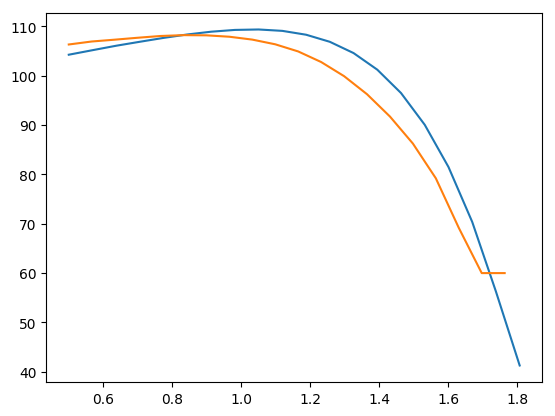

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f03e3647320>

In [144]:
PyPlot.plot(sfmubdf[!, :mu_b], sfmubdf[!, :firm_value])
PyPlot.plot(rfmubdf[!, :mu_b], rfmubdf[!, :firm_value])

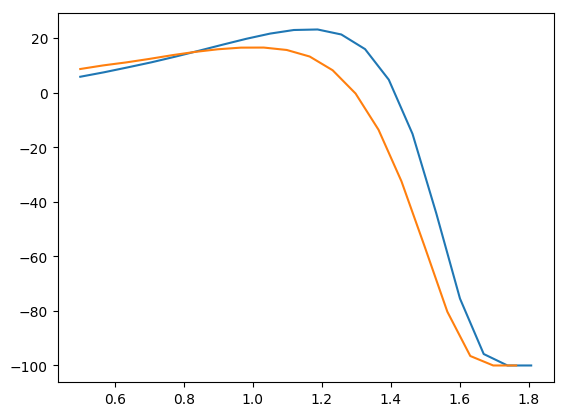

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f03e35ab518>

In [145]:
PyPlot.plot(sfmubdf[!, :mu_b], sfmubdf[!, :MBR])
PyPlot.plot(rfmubdf[!, :mu_b], rfmubdf[!, :MBR])

In [92]:
function fv(rf, jks, mu_b)
    # Compute Optimal Default Barrier
    vbl2 = FullInfoEq.find_full_info_vb(rf, jks; mu_b=mu_b)
    
    # Compute Firm Value
    eqdf = EqFinDiff.eq_fd(rf; vbl=vbl2, mu_b=mu_b, m=jks.m, c=jks.c, p=jks.p)
    
    return eqdf
end

fv (generic function with 1 method)

In [103]:
mu_b_grid = range(.5, 1.5; length=25)
eqdf_vec  = fetch(@spawn [fv(jf.rf, jf.jks, mub) for mub in mu_b_grid])
eqdf = vcat(eqdf_vec...)

Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008080005645751953
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.5409334250475
Equity Core Function Computation Time: 0.05690598487854004
Total Equity FD Core Function Computation Time: 0.10488319396972656
Total computation time: 0.1349620819091797
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Eq

Computing equity values... 
V0: 100.0; equity: 78.5435107653089
Equity Core Function Computation Time: 0.035954952239990234
Total Equity FD Core Function Computation Time: 0.07642292976379395
Total computation time: 0.1071920394897461
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0081939697265625
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.54288935610911
Equity Core Function Computation Time: 0.03330588340759277
Total Equity FD Core Function Computation Time: 0.07637286186218262
Total computation time: 0.10702109336853027
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi

Computing equity values... 
V0: 100.0; equity: 76.55736375929438
Equity Core Function Computation Time: 0.036293983459472656
Total Equity FD Core Function Computation Time: 0.07697510719299316
Total computation time: 0.1101529598236084
Computing Equity Vmax
Vmax: 125.0
phi0: -21.94972974208482
phi1: 0.9999999999999998
pv_rfdebt: 29.261859143839793
debt_abs_per_diff: 7.996200906950111e-7
eq_abs_per_diff: 0.000950941047562693
Equity Vmax: 331.6622131430528
 
eq_max: 309.71244969408707
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008152961730957031
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 76.55707101586435
Equity Core Function Computation Time: 0.033180952072143555
Total Equity FD Core Function Computation Time: 0.0768117904663086
Total computation time: 0.10994601249694824
Computing Equity Vmax
Vmax: 125.0
phi0: -21.94972974208482
phi

Computing equity values... 
V0: 100.0; equity: 74.49115791394199
Equity Core Function Computation Time: 0.03542804718017578
Total Equity FD Core Function Computation Time: 0.07536506652832031
Total computation time: 0.1104888916015625
Computing Equity Vmax
Vmax: 125.0
phi0: -23.638170491475964
phi1: 0.9999999999999998
pv_rfdebt: 31.512771385673627
debt_abs_per_diff: 1.43617597002426e-7
eq_abs_per_diff: 0.0008894659226565985
Equity Vmax: 365.65758999021574
 
eq_max: 342.01938767208867
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008115053176879883
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 74.47832010546685
Equity Core Function Computation Time: 0.03268289566040039
Total Equity FD Core Function Computation Time: 0.0749368667602539
Total computation time: 0.11018610000610352
Computing Equity Vmax
Vmax: 125.0
phi0: -23.638170491475964
ph

Computing equity values... 
V0: 100.0; equity: 74.4680188292847
Equity Core Function Computation Time: 0.035540103912353516
Total Equity FD Core Function Computation Time: 0.07553505897521973
Total computation time: 0.11100482940673828
Computing Equity Vmax
Vmax: 125.0
phi0: -25.326611240867102
phi1: 0.9999999999999998
pv_rfdebt: 33.763683627507454
debt_abs_per_diff: 7.39649154513793e-8
eq_abs_per_diff: 0.0009421271006435353
Equity Vmax: 383.9404694897265
 
eq_max: 358.6138200622718
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008074045181274414
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 72.42732802570912
Equity Core Function Computation Time: 0.03273606300354004
Total Equity FD Core Function Computation Time: 0.07513093948364258
Total computation time: 0.111602783203125
Computing Equity Vmax
Vmax: 125.0
phi0: -25.326611240867102
phi1

Computing equity values... 
V0: 100.0; equity: 72.44493215813242
Equity Core Function Computation Time: 0.035774946212768555
Total Equity FD Core Function Computation Time: 0.07566308975219727
Total computation time: 0.11258602142333984
Computing Equity Vmax
Vmax: 125.0
phi0: -25.326611240867102
phi1: 0.9999999999999998
pv_rfdebt: 33.763683627507454
debt_abs_per_diff: 7.39649154513793e-8
eq_abs_per_diff: 0.0009421271006435353
Equity Vmax: 383.9404694897265
 
eq_max: 358.6138200622718
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00819706916809082
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 72.44069356946933
Equity Core Function Computation Time: 0.03257489204406738
Total Equity FD Core Function Computation Time: 0.07511019706726074
Total computation time: 0.11209297180175781
Computing Equity Vmax
Vmax: 125.0
phi0: -25.326611240867102
ph

Computing equity values... 
V0: 100.0; equity: 70.11041290399515
Equity Core Function Computation Time: 0.03198719024658203
Total Equity FD Core Function Computation Time: 0.07464790344238281
Total computation time: 0.1128530502319336
Computing Equity Vmax
Vmax: 125.0
phi0: -27.015051990258243
phi1: 0.9999999999999998
pv_rfdebt: 36.014595869341285
debt_abs_per_diff: 5.0776230070817663e-8
eq_abs_per_diff: 0.0009853516723614215
Equity Vmax: 403.13749296421287
 
eq_max: 376.12239648440055
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008151054382324219
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 70.1019461318067
Equity Core Function Computation Time: 0.03220009803771973
Total Equity FD Core Function Computation Time: 0.07461404800415039
Total computation time: 0.11277413368225098
Computing Equity Vmax
Vmax: 125.0
phi0: -27.015051990258243


Computing equity values... 
V0: 100.0; equity: 67.98358067818756
Equity Core Function Computation Time: 0.03205394744873047
Total Equity FD Core Function Computation Time: 0.0706629753112793
Total computation time: 0.11492013931274414
Computing Equity Vmax
Vmax: 125.0
phi0: -28.703492739649384
phi1: 0.9999999999999998
pv_rfdebt: 38.26550811117512
debt_abs_per_diff: 4.1138317410943804e-8
eq_abs_per_diff: 0.0008869261123846178
Equity Vmax: 444.4590859930447
 
eq_max: 415.7555548236627
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008189916610717773
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 67.952002540748
Equity Core Function Computation Time: 0.031954050064086914
Total Equity FD Core Function Computation Time: 0.07083892822265625
Total computation time: 0.1151728630065918
Computing Equity Vmax
Vmax: 125.0
phi0: -28.703492739649384
phi1

Computing equity values... 
V0: 100.0; equity: 67.91960498139096
Equity Core Function Computation Time: 0.03207898139953613
Total Equity FD Core Function Computation Time: 0.0708780288696289
Total computation time: 0.1151430606842041
Computing Equity Vmax
Vmax: 125.0
phi0: -30.39193348904052
phi1: 0.9999999999999998
pv_rfdebt: 40.51642035300895
debt_abs_per_diff: 4.031181648640912e-8
eq_abs_per_diff: 0.0009083071067474515
Equity Vmax: 466.68204029269697
 
eq_max: 436.2900641602052
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00808095932006836
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 65.8178585790619
Equity Core Function Computation Time: 0.032074928283691406
Total Equity FD Core Function Computation Time: 0.07099199295043945
Total computation time: 0.11651277542114258
Computing Equity Vmax
Vmax: 125.0
phi0: -30.39193348904052
phi1: 

Computing equity values... 
V0: 100.0; equity: 65.69100053648883
Equity Core Function Computation Time: 0.03209805488586426
Total Equity FD Core Function Computation Time: 0.07074189186096191
Total computation time: 0.11646699905395508
Computing Equity Vmax
Vmax: 125.0
phi0: -30.39193348904052
phi1: 0.9999999999999998
pv_rfdebt: 40.51642035300895
debt_abs_per_diff: 4.031181648640912e-8
eq_abs_per_diff: 0.0009083071067474515
Equity Vmax: 466.68204029269697
 
eq_max: 436.2900641602052
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00819706916809082
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 65.6744591559327
Equity Core Function Computation Time: 0.03202009201049805
Total Equity FD Core Function Computation Time: 0.0709230899810791
Total computation time: 0.11656689643859863
Computing Equity Vmax
Vmax: 125.0
phi0: -30.39193348904052
phi1: 

V0: 100.0; equity: 63.41001706621086
Equity Core Function Computation Time: 0.03273296356201172
Total Equity FD Core Function Computation Time: 0.0736088752746582
Total computation time: 0.12054991722106934
Computing Equity Vmax
Vmax: 125.0
phi0: -32.080374238431666
phi1: 0.9999999999999998
pv_rfdebt: 42.76733259484278
debt_abs_per_diff: 4.007029263986478e-8
eq_abs_per_diff: 0.0009220567505924087
Equity Vmax: 490.01614230733185
 
eq_max: 457.9357217056966
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008156061172485352
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 63.414345700577535
Equity Core Function Computation Time: 0.03276395797729492
Total Equity FD Core Function Computation Time: 0.07339215278625488
Total computation time: 0.12032103538513184
Computing Equity Vmax
Vmax: 125.0
phi0: -32.080374238431666
phi1: 0.9999999999999998
pv_r

V0: 100.0; equity: 61.046541051053325
Equity Core Function Computation Time: 0.03318190574645996
Total Equity FD Core Function Computation Time: 0.07527709007263184
Total computation time: 0.12367105484008789
Computing Equity Vmax
Vmax: 125.0
phi0: -33.7688149878228
phi1: 0.9999999999999998
pv_rfdebt: 45.01824483667661
debt_abs_per_diff: 4.000240313293955e-8
eq_abs_per_diff: 0.0009286520500719939
Equity Vmax: 514.5169494226984
 
eq_max: 480.7480849422631
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00812387466430664
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 61.05335966620139
Equity Core Function Computation Time: 0.03333401679992676
Total Equity FD Core Function Computation Time: 0.07575511932373047
Total computation time: 0.12408590316772461
Computing Equity Vmax
Vmax: 125.0
phi0: -33.7688149878228
phi1: 0.9999999999999998
pv_rfdebt

V0: 100.0; equity: 61.05762951141461
Equity Core Function Computation Time: 0.03344297409057617
Total Equity FD Core Function Computation Time: 0.07605791091918945
Total computation time: 0.12587189674377441
Computing Equity Vmax
Vmax: 125.0
phi0: -35.45725573721394
phi1: 0.9999999999999998
pv_rfdebt: 47.26915707851044
debt_abs_per_diff: 3.998411693619209e-8
eq_abs_per_diff: 0.0009286520500718701
Equity Vmax: 540.2427968938333
 
eq_max: 504.78548918937645
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008088111877441406
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 58.65900750405803
Equity Core Function Computation Time: 0.03357982635498047
Total Equity FD Core Function Computation Time: 0.0760650634765625
Total computation time: 0.12600088119506836
Computing Equity Vmax
Vmax: 125.0
phi0: -35.45725573721394
phi1: 0.9999999999999998
pv_rfde

V0: 100.0; equity: 58.47544851126398
Equity Core Function Computation Time: 0.03211379051208496
Total Equity FD Core Function Computation Time: 0.07076001167297363
Total computation time: 0.12030291557312012
Computing Equity Vmax
Vmax: 125.0
phi0: -35.45725573721394
phi1: 0.9999999999999998
pv_rfdebt: 47.26915707851044
debt_abs_per_diff: 3.998411693619209e-8
eq_abs_per_diff: 0.0009286520500718701
Equity Vmax: 540.2427968938333
 
eq_max: 504.7854891893762
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0081939697265625
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 58.3710136197751
Equity Core Function Computation Time: 0.03229999542236328
Total Equity FD Core Function Computation Time: 0.07127213478088379
Total computation time: 0.12090396881103516
Computing Equity Vmax
Vmax: 125.0
phi0: -35.45725573721394
phi1: 0.9999999999999998
pv_rfdebt:

V0: 100.0; equity: 56.19289432345598
Equity Core Function Computation Time: 0.03218197822570801
Total Equity FD Core Function Computation Time: 0.07050204277038574
Total computation time: 0.12174010276794434
Computing Equity Vmax
Vmax: 125.0
phi0: -37.14569648660508
phi1: 0.9999999999999998
pv_rfdebt: 49.52006932034427
debt_abs_per_diff: 3.997942195743504e-8
eq_abs_per_diff: 0.0009226686151781976
Equity Vmax: 567.254936738525
 
eq_max: 530.1091864980916
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008153915405273438
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 56.147238100358166
Equity Core Function Computation Time: 0.03203082084655762
Total Equity FD Core Function Computation Time: 0.0704810619354248
Total computation time: 0.12123703956604004
Computing Equity Vmax
Vmax: 125.0
phi0: -37.14569648660508
phi1: 0.9999999999999998
pv_rfdeb

V0: 100.0; equity: 53.75087385529176
Equity Core Function Computation Time: 0.05595993995666504
Total Equity FD Core Function Computation Time: 0.10029220581054688
Total computation time: 0.15228915214538574
Computing Equity Vmax
Vmax: 125.0
phi0: -38.834137235996224
phi1: 0.9999999999999998
pv_rfdebt: 51.7709815621781
debt_abs_per_diff: 3.997828204375923e-8
eq_abs_per_diff: 0.0009113418878422731
Equity Vmax: 595.6176835754512
 
eq_max: 556.7834914917486
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008281946182250977
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 53.745489842229894
Equity Core Function Computation Time: 0.03229403495788574
Total Equity FD Core Function Computation Time: 0.07185983657836914
Total computation time: 0.24049901962280273
Computing Equity Vmax
Vmax: 125.0
phi0: -38.834137235996224
phi1: 0.9999999999999998
pv_rf

Computing equity values... 
V0: 100.0; equity: 53.49805489498468
Equity Core Function Computation Time: 0.035331010818481445
Total Equity FD Core Function Computation Time: 0.07419490814208984
Total computation time: 0.1261119842529297
Computing Equity Vmax
Vmax: 125.0
phi0: -40.522577985387365
phi1: 0.9999999999999998
pv_rfdebt: 54.02189380401193
debt_abs_per_diff: 3.99780234012253e-8
eq_abs_per_diff: 0.0008953201290004833
Equity Vmax: 625.3985677542238
 
eq_max: 584.8759344998025
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008254051208496094
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 51.143475431712695
Equity Core Function Computation Time: 0.03550004959106445
Total Equity FD Core Function Computation Time: 0.08227109909057617
Total computation time: 0.13656902313232422
Computing Equity Vmax
Vmax: 125.0
phi0: -40.522577985387365
ph

Computing equity values... 
V0: 100.0; equity: 50.237800295699984
Equity Core Function Computation Time: 0.033969879150390625
Total Equity FD Core Function Computation Time: 0.08430194854736328
Total computation time: 0.13761115074157715
Computing Equity Vmax
Vmax: 125.0
phi0: -40.522577985387365
phi1: 0.9999999999999998
pv_rfdebt: 54.02189380401193
debt_abs_per_diff: 3.99780234012253e-8
eq_abs_per_diff: 0.0008953201290004833
Equity Vmax: 625.3985677542238
 
eq_max: 584.8759344998027
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008188962936401367
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 49.88484848297688
Equity Core Function Computation Time: 0.03258109092712402
Total Equity FD Core Function Computation Time: 0.07328081130981445
Total computation time: 0.12665700912475586
Computing Equity Vmax
Vmax: 125.0
phi0: -40.522577985387365
p

debt_abs_per_diff: 3.997797030573542e-8
eq_abs_per_diff: 0.0008752435547087885
Equity Vmax: 656.668496141935
 
eq_max: 614.4574223488685
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00816202163696289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 48.07734290719143
Equity Core Function Computation Time: 0.03235912322998047
Total Equity FD Core Function Computation Time: 0.07195496559143066
Total computation time: 0.12682580947875977
Computing Equity Vmax
Vmax: 125.0
phi0: -42.21101873477851
phi1: 0.9999999999999998
pv_rfdebt: 56.27280604584577
debt_abs_per_diff: 3.997797030573542e-8
eq_abs_per_diff: 0.0008752435547087885
Equity Vmax: 656.668496141935
 
eq_max: 614.457422348868
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008

Computing equity values... 
V0: 100.0; equity: 45.84708615159622
Equity Core Function Computation Time: 0.03199195861816406
Total Equity FD Core Function Computation Time: 0.07147908210754395
Total computation time: 0.12601590156555176
Computing Equity Vmax
Vmax: 125.0
phi0: -43.89945948416964
phi1: 0.9999999999999998
pv_rfdebt: 58.523718287679586
debt_abs_per_diff: 3.99779637883891e-8
eq_abs_per_diff: 0.0009786545193098592
Equity Vmax: 656.668496141935
 
eq_max: 612.768965325367
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008116006851196289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 45.735510766300216
Equity Core Function Computation Time: 0.0359499454498291
Total Equity FD Core Function Computation Time: 0.07491898536682129
Total computation time: 0.12940216064453125
Computing Equity Vmax
Vmax: 125.0
phi0: -43.89945948416964
phi1: 

V0: 100.0; equity: 43.27853912128838
Equity Core Function Computation Time: 0.03239107131958008
Total Equity FD Core Function Computation Time: 0.07201099395751953
Total computation time: 0.12777996063232422
Computing Equity Vmax
Vmax: 125.0
phi0: -45.58790023356078
phi1: 0.9999999999999998
pv_rfdebt: 60.77463052951342
debt_abs_per_diff: 3.997795915678154e-8
eq_abs_per_diff: 0.000948331212379114
Equity Vmax: 689.5019209490317
 
eq_max: 643.9139510863233
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008072853088378906
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 43.319358529807886
Equity Core Function Computation Time: 0.0323028564453125
Total Equity FD Core Function Computation Time: 0.07132101058959961
Total computation time: 0.12721896171569824
Computing Equity Vmax
Vmax: 125.0
phi0: -45.58790023356078
phi1: 0.9999999999999998
pv_rfdeb

V0: 100.0; equity: 39.43631817298661
Equity Core Function Computation Time: 0.03254103660583496
Total Equity FD Core Function Computation Time: 0.07171010971069336
Total computation time: 0.1276719570159912
Computing Equity Vmax
Vmax: 125.0
phi0: -45.58790023356078
phi1: 0.9999999999999998
pv_rfdebt: 60.77463052951342
debt_abs_per_diff: 3.997795915678154e-8
eq_abs_per_diff: 0.000948331212379114
Equity Vmax: 689.5019209490317
 
eq_max: 643.9139510863236
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008198976516723633
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 38.33880257349986
Equity Core Function Computation Time: 0.03213310241699219
Total Equity FD Core Function Computation Time: 0.07108092308044434
Total computation time: 0.12711310386657715
Computing Equity Vmax
Vmax: 125.0
phi0: -45.58790023356078
phi1: 0.9999999999999998
pv_rfdebt

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008306026458740234
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 38.836130519411284
Equity Core Function Computation Time: 0.03191208839416504
Total Equity FD Core Function Computation Time: 0.07162809371948242
Total computation time: 0.1292719841003418
Computing Equity Vmax
Vmax: 125.0
phi0: -47.27634098295193
phi1: 0.9999999999999998
pv_rfdebt: 63.025542771347254
debt_abs_per_diff: 3.997795936555719e-8
eq_abs_per_diff: 0.0009153714915196766
Equity Vmax: 723.9770169964834
 
eq_max: 676.7006086601808
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008156061172485352
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 38.240319050352866
Equity Core Function Computation Time: 0.031858205795288086
Total Equity F

V0: 100.0; equity: 37.24030758840201
Equity Core Function Computation Time: 0.032584190368652344
Total Equity FD Core Function Computation Time: 0.07258009910583496
Total computation time: 0.13107609748840332
Computing Equity Vmax
Vmax: 125.0
phi0: -48.964781732343056
phi1: 0.9999999999999998
pv_rfdebt: 65.27645501318108
debt_abs_per_diff: 3.997795945108322e-8
eq_abs_per_diff: 0.0008803636913333299
Equity Vmax: 760.1758678463076
 
eq_max: 711.2110215087591
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0081329345703125
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 36.92203590123609
Equity Core Function Computation Time: 0.03309988975524902
Total Equity FD Core Function Computation Time: 0.07452988624572754
Total computation time: 0.1332409381866455
Computing Equity Vmax
Vmax: 125.0
phi0: -48.964781732343056
phi1: 0.9999999999999998
pv_rfde

Total computation time: 0.13295507431030273
Computing Equity Vmax
Vmax: 125.0
phi0: -50.653222481734204
phi1: 0.9999999999999998
pv_rfdebt: 67.52736725501491
debt_abs_per_diff: 3.9977959320461653e-8
eq_abs_per_diff: 0.0009695812698223172
Equity Vmax: 760.1758678463076
 
eq_max: 709.5225645519673
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008079051971435547
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 34.96514753472606
Equity Core Function Computation Time: 0.03281402587890625
Total Equity FD Core Function Computation Time: 0.07376289367675781
Total computation time: 0.13240718841552734
Computing Equity Vmax
Vmax: 125.0
phi0: -50.653222481734204
phi1: 0.9999999999999998
pv_rfdebt: 67.52736725501491
debt_abs_per_diff: 3.9977959320461653e-8
eq_abs_per_diff: 0.0009695812698223172
Equity Vmax: 760.1758678463076
 
eq_max: 709.5225645519678


V0: 100.0; equity: 26.618220439512875
Equity Core Function Computation Time: 0.032423973083496094
Total Equity FD Core Function Computation Time: 0.0715939998626709
Total computation time: 0.13037705421447754
Computing Equity Vmax
Vmax: 125.0
phi0: -50.653222481734204
phi1: 0.9999999999999998
pv_rfdebt: 67.52736725501491
debt_abs_per_diff: 3.9977959320461653e-8
eq_abs_per_diff: 0.0009695812698223172
Equity Vmax: 760.1758678463076
 
eq_max: 709.5225645519678
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008199930191040039
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 24.51845539698807
Equity Core Function Computation Time: 0.03238487243652344
Total Equity FD Core Function Computation Time: 0.07108187675476074
Total computation time: 0.1298351287841797
Computing Equity Vmax
Vmax: 125.0
phi0: -50.653222481734204
phi1: 0.9999999999999998
pv_r

V0: 100.0; equity: 28.085198393748076
Equity Core Function Computation Time: 0.032337188720703125
Total Equity FD Core Function Computation Time: 0.07120203971862793
Total computation time: 0.1311960220336914
Computing Equity Vmax
Vmax: 125.0
phi0: -52.341663231125345
phi1: 0.9999999999999998
pv_rfdebt: 69.77827949684875
debt_abs_per_diff: 3.9977959605581844e-8
eq_abs_per_diff: 0.0009263898617439511
Equity Vmax: 798.184661238623
 
eq_max: 745.8429216612053
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008162975311279297
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 26.95655408443589
Equity Core Function Computation Time: 0.032135963439941406
Total Equity FD Core Function Computation Time: 0.07105183601379395
Total computation time: 0.130842924118042
Computing Equity Vmax
Vmax: 125.0
phi0: -52.341663231125345
phi1: 0.9999999999999998
pv_rf

Computing equity values... 
V0: 100.0; equity: 27.740306266644968
Equity Core Function Computation Time: 0.03224301338195801
Total Equity FD Core Function Computation Time: 0.07305192947387695
Total computation time: 0.1340479850769043
Computing Equity Vmax
Vmax: 125.0
phi0: -54.030103980516486
phi1: 0.9999999999999998
pv_rfdebt: 72.02919173868257
debt_abs_per_diff: 3.997795967558904e-8
eq_abs_per_diff: 0.0008825205123715362
Equity Vmax: 838.0938943005542
 
eq_max: 784.0637186873244
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00826716423034668
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 27.053850372766675
Equity Core Function Computation Time: 0.03223896026611328
Total Equity FD Core Function Computation Time: 0.07189202308654785
Total computation time: 0.13283300399780273
Computing Equity Vmax
Vmax: 125.0
phi0: -54.030103980516486
ph

Computing equity values... 
V0: 100.0; equity: 26.477833794967182
Equity Core Function Computation Time: 0.03213691711425781
Total Equity FD Core Function Computation Time: 0.0713810920715332
Total computation time: 0.13233089447021484
Computing Equity Vmax
Vmax: 125.0
phi0: -55.71854472990763
phi1: 0.9999999999999998
pv_rfdebt: 74.2801039805164
debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0009633316141674656
Equity Vmax: 838.0938943005542
 
eq_max: 782.3752618002355
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008214950561523438
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 26.16396341520972
Equity Core Function Computation Time: 0.03200697898864746
Total Equity FD Core Function Computation Time: 0.07145309448242188
Total computation time: 0.13254594802856445
Computing Equity Vmax
Vmax: 125.0
phi0: -55.71854472990763
phi1:

V0: 100.0; equity: 12.111759279831874
Equity Core Function Computation Time: 0.03221011161804199
Total Equity FD Core Function Computation Time: 0.07151508331298828
Total computation time: 0.13243603706359863
Computing Equity Vmax
Vmax: 125.0
phi0: -55.71854472990763
phi1: 0.9999999999999998
pv_rfdebt: 74.2801039805164
debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0009633316141674656
Equity Vmax: 838.0938943005542
 
eq_max: 782.375261800236
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008199930191040039
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 8.481566933248635
Equity Core Function Computation Time: 0.03219413757324219
Total Equity FD Core Function Computation Time: 0.07158493995666504
Total computation time: 0.1324608325958252
Computing Equity Vmax
Vmax: 125.0
phi0: -55.71854472990763
phi1: 0.9999999999999998
pv_rfdebt

V0: 100.0; equity: 16.274564567311312
Equity Core Function Computation Time: 0.032058000564575195
Total Equity FD Core Function Computation Time: 0.07092499732971191
Total computation time: 0.13344192504882812
Computing Equity Vmax
Vmax: 125.0
phi0: -57.40698547929877
phi1: 0.9999999999999998
pv_rfdebt: 76.53101622235025
debt_abs_per_diff: 3.997795961756168e-8
eq_abs_per_diff: 0.0009127570227677423
Equity Vmax: 879.998589015582
 
eq_max: 822.5915222091204
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008156061172485352
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 14.697191279559755
Equity Core Function Computation Time: 0.03202414512634277
Total Equity FD Core Function Computation Time: 0.07133197784423828
Total computation time: 0.13375496864318848
Computing Equity Vmax
Vmax: 125.0
phi0: -57.40698547929877
phi1: 0.9999999999999998
pv_rf

Computing equity values... 
V0: 100.0; equity: 17.464263515736928
Equity Core Function Computation Time: 0.03212904930114746
Total Equity FD Core Function Computation Time: 0.0714418888092041
Total computation time: 0.13383984565734863
Computing Equity Vmax
Vmax: 125.0
phi0: -59.0954262286899
phi1: 0.9999999999999998
pv_rfdebt: 78.78192846418406
debt_abs_per_diff: 3.997795968122598e-8
eq_abs_per_diff: 0.0009913120848975261
Equity Vmax: 879.998589015582
 
eq_max: 820.9030643049869
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0082550048828125
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 16.324945375642404
Equity Core Function Computation Time: 0.031896114349365234
Total Equity FD Core Function Computation Time: 0.0712730884552002
Total computation time: 0.1335618495941162
Computing Equity Vmax
Vmax: 125.0
phi0: -59.0954262286899
phi1: 0.9

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008231163024902344
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 17.896137121885886
Equity Core Function Computation Time: 0.032385826110839844
Total Equity FD Core Function Computation Time: 0.07318401336669922
Total computation time: 0.1369919776916504
Computing Equity Vmax
Vmax: 125.0
phi0: -60.78386697808104
phi1: 0.9999999999999998
pv_rfdebt: 81.0328407060179
debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0009347666028996956
Equity Vmax: 923.9985184663611
 
eq_max: 863.2145612438086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00808405876159668
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 17.15182334689113
Equity Core Function Computation Time: 0.03295302391052246
Total Equity FD Co

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00833892822265625
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03202199935913086
Total Equity FD Core Function Computation Time: 0.07132101058959961
Total computation time: 0.13471603393554688
Computing Equity Vmax
Vmax: 125.0
phi0: -60.78386697808104
phi1: 0.9999999999999998
pv_rfdebt: 81.0328407060179
debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0009347666028996956
Equity Vmax: 923.9985184663611
 
eq_max: 863.2145612438086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008195877075195312
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03196907043457031
Total Equity FD Core Function Computation Time:

,MBR,V0,alpha,c,debt,delta,eq_deriv,eq_deriv_min_val,eq_min_val,eq_negative,eq_vb,equity,firm_value,gross_delta,iota,kappa,lambda,leverage,m,mu_b,p,pi,r,sigmah,sigmal,vb,xi
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7.61186,100.0,0.6,4.5,27.0109,0.02,0.69928,0.521891,0.0276137,0,0.0,78.5449,105.556,0.02,0.0,0.0025,0.2,25.5893,1.0,0.5,54.0,0.27,0.08,0.275,0.15,23.2633,1.0
2,8.20142,100.0,0.6,4.5,29.2619,0.02,-2.75479,-2.75479,-2.35871,1,0.0,76.5397,105.802,0.02,0.0,0.0025,0.2,27.6573,1.0,0.541667,54.0,0.27,0.08,0.275,0.15,26.3062,1.0
3,8.73271,100.0,0.6,4.5,31.5128,0.02,-1.98065,-1.98065,-1.53911,1,0.0,74.468,105.981,0.02,0.0,0.0025,0.2,29.7344,1.0,0.583333,54.0,0.27,0.08,0.275,0.15,30.5793,1.0
4,9.06569,100.0,0.6,4.5,33.7167,0.02,-1.09403,-1.09403,-0.607636,1,0.0,72.2923,106.009,0.02,0.0,0.0025,0.2,31.8055,1.0,0.625,54.0,0.27,0.08,0.275,0.15,35.0788,1.0
5,9.46547,100.0,0.6,4.5,35.9604,0.02,-0.232874,-0.232874,-0.0359423,0,0.0,70.1013,106.062,0.02,0.0,0.0025,0.2,33.9052,1.0,0.666667,54.0,0.27,0.08,0.275,0.15,39.729,1.0
6,9.95754,100.0,0.6,4.5,38.2311,0.02,-0.0421203,-0.0421203,-0.00130424,0,0.0,67.9196,106.151,0.02,0.0,0.0025,0.2,36.0158,1.0,0.708333,54.0,0.27,0.08,0.275,0.15,42.7728,1.0
7,10.43,100.0,0.6,4.5,40.5078,0.02,-0.00204771,-0.00204771,0.00141941,0,0.0,65.6972,106.205,0.02,0.0,0.0025,0.2,38.1412,1.0,0.75,54.0,0.27,0.08,0.275,0.15,45.415,1.0
8,10.7986,100.0,0.6,4.5,42.7673,0.02,0.000227963,0.000227963,0.00165898,0,0.0,63.413,106.18,0.02,0.0,0.0025,0.2,40.278,1.0,0.791667,54.0,0.27,0.08,0.275,0.15,47.9456,1.0
9,11.0507,100.0,0.6,4.5,45.0182,0.02,-1.75918e-5,-1.75918e-5,0.00172354,0,0.0,61.0576,106.076,0.02,0.0,0.0025,0.2,42.4397,1.0,0.833333,54.0,0.27,0.08,0.275,0.15,50.4682,1.0


In [104]:
tmp = FullInfoEq.form_mu_b_vb_pairs(jf.rf, jf.jks)

COUNT: 0
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008083105087280273
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.5409334250475
Equity Core Function Computation Time: 0.05917215347290039
Total Equity FD Core Function Computation Time: 0.11649799346923828
Total computation time: 0.14663004875183105
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Vol

Computing equity values... 
V0: 100.0; equity: 78.5435107653089
Equity Core Function Computation Time: 0.037368059158325195
Total Equity FD Core Function Computation Time: 0.08014798164367676
Total computation time: 0.1107630729675293
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008265972137451172
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.54288935610911
Equity Core Function Computation Time: 0.034126996994018555
Total Equity FD Core Function Computation Time: 0.07947802543640137
Total computation time: 0.11019301414489746
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682


V0: 100.0; equity: 66.40031487289986
Equity Core Function Computation Time: 0.034148216247558594
Total Equity FD Core Function Computation Time: 0.07973504066467285
Total computation time: 0.12064695358276367
Computing Equity Vmax
Vmax: 125.0
phi0: -29.858741673443316
phi1: 0.9999999999999998
pv_rfdebt: 39.8056059608509
debt_abs_per_diff: 4.101445996786744e-8
eq_abs_per_diff: 0.0009924041138434988
Equity Vmax: 444.4590859930447
 
eq_max: 414.60029445248034
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008237123489379883
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 66.40772726156113
Equity Core Function Computation Time: 0.0395200252532959
Total Equity FD Core Function Computation Time: 0.08470010757446289
Total computation time: 0.12569379806518555
Computing Equity Vmax
Vmax: 125.0
phi0: -29.858741673443316
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 52.78091232579226
Equity Core Function Computation Time: 0.03211498260498047
Total Equity FD Core Function Computation Time: 0.07477283477783203
Total computation time: 0.12325191497802734
Computing Equity Vmax
Vmax: 125.0
phi0: -39.45619435419297
phi1: 0.9999999999999998
pv_rfdebt: 52.60026501969583
debt_abs_per_diff: 3.997824474618764e-8
eq_abs_per_diff: 0.0009535290776268875
Equity Vmax: 595.6176835754512
 
eq_max: 556.1614283059492
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008131027221679688
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 52.73598412927616
Equity Core Function Computation Time: 0.03736400604248047
Total Equity FD Core Function Computation Time: 0.0792379379272461
Total computation time: 0.12773990631103516
Computing Equity Vmax
Vmax: 125.0
phi0: -39.45619435419297
phi1: 0.9999999999999998
pv_rfdeb

V0: 100.0; equity: 37.53161312867279
Equity Core Function Computation Time: 0.033003807067871094
Total Equity FD Core Function Computation Time: 0.07611799240112305
Total computation time: 0.13121390342712402
Computing Equity Vmax
Vmax: 125.0
phi0: -49.0536470349426
phi1: 0.9999999999999998
pv_rfdebt: 65.39492407854075
debt_abs_per_diff: 3.9977959226676e-8
eq_abs_per_diff: 0.0008849187539113356
Equity Vmax: 760.1758678463076
 
eq_max: 711.1221554280538
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00810098648071289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 37.33781056472787
Equity Core Function Computation Time: 0.03813982009887695
Total Equity FD Core Function Computation Time: 0.08072590827941895
Total computation time: 0.13585305213928223
Computing Equity Vmax
Vmax: 125.0
phi0: -49.0536470349426
phi1: 0.9999999999999998
pv_rfdebt: 

Computing equity values... 
V0: 100.0; equity: 27.029617183305287
Equity Core Function Computation Time: 0.03306698799133301
Total Equity FD Core Function Computation Time: 0.07687497138977051
Total computation time: 0.1322801113128662
  2.724253 seconds (996.42 k allocations: 2.351 GiB, 35.16% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt: 78.1895831373857
debt_abs_per_diff: 3.99779597126562e-8
eq_abs_per_diff: 0.0009702249731399367
Equity Vmax: 879.998589015582
 
eq_max: 821.3473956051791
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008224010467529297
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 21.488147960608426
Equity Core Function Computation Time: 0.03866910934448242
Total Equity FD Core Function Computation Time: 0.08198809623718262
Total computation time: 0.14110994338989

Computing equity values... 
V0: 100.0; equity: 7.217842460394201
Equity Core Function Computation Time: 0.03245997428894043
Total Equity FD Core Function Computation Time: 0.07565999031066895
Total computation time: 0.13454699516296387
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt: 78.1895831373857
debt_abs_per_diff: 3.99779597126562e-8
eq_abs_per_diff: 0.0009702249731399367
Equity Vmax: 879.998589015582
 
eq_max: 821.3473956051791
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008193016052246094
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 3.716286125456408
Equity Core Function Computation Time: 0.03754997253417969
Total Equity FD Core Function Computation Time: 0.0804898738861084
Total computation time: 0.1394031047821045
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9

Computing equity values... 
V0: 100.0; equity: -0.04566755453836982
Equity Core Function Computation Time: 0.03272199630737305
Total Equity FD Core Function Computation Time: 0.07561302185058594
Total computation time: 0.1385021209716797
Computing Equity Vmax
Vmax: 125.0
phi0: -68.24855239644188
phi1: 0.9999999999999998
pv_rfdebt: 90.98424219623061
debt_abs_per_diff: 3.997795959338363e-8
eq_abs_per_diff: 0.0009846470441452952
Equity Vmax: 1018.7083666091632
 
eq_max: 950.459701976057
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008311033248901367
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03753089904785156
Total Equity FD Core Function Computation Time: 0.08092808723449707
Total computation time: 0.14361906051635742
Computing Equity Vmax
Vmax: 125.0
phi0: -68.24855239644188
phi1: 0.99999999

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032685041427612305
Total Equity FD Core Function Computation Time: 0.07560014724731445
Total computation time: 0.14202284812927246
Computing Equity Vmax
Vmax: 125.0
phi0: -77.84600507719152
phi1: 0.9999999999999998
pv_rfdebt: 103.77890125507555
debt_abs_per_diff: 3.997795964045467e-8
eq_abs_per_diff: 0.0009440155456860435
Equity Vmax: 1179.2822728959327
 
eq_max: 1101.4361499819397
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008273124694824219
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03826093673706055
Total Equity FD Core Function Computation Time: 0.08124208450317383
Total computation time: 0.14788603782653809
Computing Equity Vmax
Vmax: 125.0
phi0: -77.84600507719152
phi1: 0.9999999999999998
pv_

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032524824142456055
Total Equity FD Core Function Computation Time: 0.07542085647583008
Total computation time: 0.14436888694763184
Computing Equity Vmax
Vmax: 125.0
phi0: -87.44345775794116
phi1: 0.9999999999999998
pv_rfdebt: 116.57356031392048
debt_abs_per_diff: 3.997795979909766e-8
eq_abs_per_diff: 0.00099560769641364
Equity Vmax: 1300.158705867766
 
eq_max: 1212.7151011419746
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008237123489379883
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03764700889587402
Total Equity FD Core Function Computation Time: 0.08000493049621582
Total computation time: 0.14905905723571777
Computing Equity Vmax
Vmax: 125.0
phi0: -87.44345775794116
phi1: 0.9999999999999998
pv_rfd

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032720088958740234
Total Equity FD Core Function Computation Time: 0.07597494125366211
Total computation time: 0.14507699012756348
  2.908137 seconds (1.06 M allocations: 2.370 GiB, 32.35% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfdebt: 129.36821937276542
debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.000882795103322822
Equity Vmax: 1505.0962218801726
 
eq_max: 1408.0551827065476
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008072853088378906
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03763723373413086
Total Equity FD Core Function Computation Time: 0.08050084114074707
Total computation time: 0.15351009368896484
Computing Equity Vmax

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03239011764526367
Total Equity FD Core Function Computation Time: 0.07547783851623535
Total computation time: 0.14859294891357422
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfdebt: 129.36821937276542
debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.000882795103322822
Equity Vmax: 1505.0962218801726
 
eq_max: 1408.0551827065472
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008196115493774414
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03808999061584473
Total Equity FD Core Function Computation Time: 0.08120203018188477
Total computation time: 0.1543588638305664
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfde

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032488107681274414
Total Equity FD Core Function Computation Time: 0.07548999786376953
Total computation time: 0.15096211433410645
Computing Equity Vmax
Vmax: 125.0
phi0: -106.63836311944044
phi1: 0.9999999999999998
pv_rfdebt: 142.16287843161035
debt_abs_per_diff: 3.997795973083107e-8
eq_abs_per_diff: 0.0008746183521620178
Equity Vmax: 1659.3685846228905
 
eq_max: 1552.73008260436
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008160114288330078
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.038366079330444336
Total Equity FD Core Function Computation Time: 0.08168196678161621
Total computation time: 0.15744304656982422
Computing Equity Vmax
Vmax: 125.0
phi0: -106.63836311944044
phi1: 0.9999999999999998
pv

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03369903564453125
Total Equity FD Core Function Computation Time: 0.0781400203704834
Total computation time: 0.15533089637756348
Computing Equity Vmax
Vmax: 125.0
phi0: -116.23581580019007
phi1: 0.9999999999999998
pv_rfdebt: 154.95753749045528
debt_abs_per_diff: 3.997795956759073e-8
eq_abs_per_diff: 0.0009728608372686559
Equity Vmax: 1742.3370138540351
 
eq_max: 1626.1010113745144
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008130073547363281
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03863406181335449
Total Equity FD Core Function Computation Time: 0.0822591781616211
Total computation time: 0.15938997268676758
Computing Equity Vmax
Vmax: 125.0
phi0: -116.23581580019007
phi1: 0.9999999999999998
pv_r

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03252005577087402
Total Equity FD Core Function Computation Time: 0.0764310359954834
Total computation time: 0.15560698509216309
Computing Equity Vmax
Vmax: 125.0
phi0: -125.8332684809397
phi1: 0.9999999999999998
pv_rfdebt: 167.7521965493002
debt_abs_per_diff: 3.997795959867821e-8
eq_abs_per_diff: 0.0009236036559557147
Equity Vmax: 1920.926557774074
 
eq_max: 1795.0931068355405
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008102178573608398
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.037589073181152344
Total Equity FD Core Function Computation Time: 0.08073711395263672
Total computation time: 0.1600360870361328
Computing Equity Vmax
Vmax: 125.0
phi0: -125.8332684809397
phi1: 0.9999999999999998
pv_rfde

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032340049743652344
Total Equity FD Core Function Computation Time: 0.07578611373901367
Total computation time: 0.15514922142028809
  3.080502 seconds (1.15 M allocations: 2.384 GiB, 30.83% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv_rfdebt: 180.54685560814514
debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.000990955998077793
Equity Vmax: 2016.9728856627776
 
eq_max: 1881.5419389666047
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008072137832641602
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03752899169921875
Total Equity FD Core Function Computation Time: 0.08048200607299805
Total computation time: 0.16105008125305176
Computing Equity Vma

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03262805938720703
Total Equity FD Core Function Computation Time: 0.07660484313964844
Total computation time: 0.15722084045410156
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv_rfdebt: 180.54685560814514
debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.000990955998077793
Equity Vmax: 2016.9728856627776
 
eq_max: 1881.5419389666047
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008202075958251953
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.037535905838012695
Total Equity FD Core Function Computation Time: 0.08065199851989746
Total computation time: 0.16144895553588867
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03266501426696777
Total Equity FD Core Function Computation Time: 0.07637596130371094
Total computation time: 0.1595909595489502
Computing Equity Vmax
Vmax: 125.0
phi0: -145.028173842439
phi1: 0.9999999999999998
pv_rfdebt: 193.34151466699007
debt_abs_per_diff: 3.9977959648509606e-8
eq_abs_per_diff: 0.0009121047737124414
Equity Vmax: 2223.7126064432127
 
eq_max: 2078.6842274315013
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008157014846801758
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03762984275817871
Total Equity FD Core Function Computation Time: 0.08066892623901367
Total computation time: 0.16396689414978027
Computing Equity Vmax
Vmax: 125.0
phi0: -145.028173842439
phi1: 0.9999999999999998
pv_rfd

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03290081024169922
Total Equity FD Core Function Computation Time: 0.07664203643798828
Total computation time: 0.16101789474487305
Computing Equity Vmax
Vmax: 125.0
phi0: -154.62562652318863
phi1: 0.9999999999999998
pv_rfdebt: 206.136173725835
debt_abs_per_diff: 3.9977959668785834e-8
eq_abs_per_diff: 0.0009526908959113619
Equity Vmax: 2334.8982367653734
 
eq_max: 2180.272371932635
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008126974105834961
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.037615060806274414
Total Equity FD Core Function Computation Time: 0.0807499885559082
Total computation time: 0.16529607772827148
Computing Equity Vmax
Vmax: 125.0
phi0: -154.62562652318863
phi1: 0.9999999999999998
pv_r

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03348398208618164
Total Equity FD Core Function Computation Time: 0.07919883728027344
Total computation time: 0.1651930809020996
Computing Equity Vmax
Vmax: 125.0
phi0: -164.22307920393825
phi1: 0.9999999999999998
pv_rfdebt: 218.93083278467992
debt_abs_per_diff: 3.9977959686692104e-8
eq_abs_per_diff: 0.0009842167062508909
Equity Vmax: 2451.643148603642
 
eq_max: 2287.419799562292
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008111000061035156
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03860306739807129
Total Equity FD Core Function Computation Time: 0.08337807655334473
Total computation time: 0.1695098876953125
Computing Equity Vmax
Vmax: 125.0
phi0: -164.22307920393825
phi1: 0.9999999999999998
pv_rf

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03248000144958496
Total Equity FD Core Function Computation Time: 0.08560705184936523
Total computation time: 0.17186713218688965
  3.246926 seconds (1.21 M allocations: 2.393 GiB, 30.51% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_rfdebt: 231.72549184352488
debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0008763085238681335
Equity Vmax: 2702.9365713355155
 
eq_max: 2529.1158121831854
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008073091506958008
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.04182791709899902
Total Equity FD Core Function Computation Time: 0.08446598052978516
Total computation time: 0.17272186279296875
Computing Equity Vmax

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.033010005950927734
Total Equity FD Core Function Computation Time: 0.07697081565856934
Total computation time: 0.16582894325256348
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_rfdebt: 231.72549184352488
debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0008763085238681335
Equity Vmax: 2702.9365713355155
 
eq_max: 2529.1158121831854
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008190155029296875
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03762102127075195
Total Equity FD Core Function Computation Time: 0.08052992820739746
Total computation time: 0.16902995109558105
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032788991928100586
Total Equity FD Core Function Computation Time: 0.07697606086730957
Total computation time: 0.1673269271850586
Computing Equity Vmax
Vmax: 125.0
phi0: -183.41798456543754
phi1: 0.9999999999999998
pv_rfdebt: 244.52015090236978
debt_abs_per_diff: 3.997795971688292e-8
eq_abs_per_diff: 0.0008887520701284153
Equity Vmax: 2838.0833999022916
 
eq_max: 2654.665168771155
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008207082748413086
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03771805763244629
Total Equity FD Core Function Computation Time: 0.08096790313720703
Total computation time: 0.17089104652404785
Computing Equity Vmax
Vmax: 125.0
phi0: -183.41798456543754
phi1: 0.9999999999999998
pv_

debt_abs_per_diff: 3.997795972972652e-8
eq_abs_per_diff: 0.0008943665149018506
Equity Vmax: 2979.9875698974065
 
eq_max: 2786.971869947686
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008138895034790039
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03812694549560547
Total Equity FD Core Function Computation Time: 0.08143997192382812
Total computation time: 0.1726229190826416
Computing Equity Vmax
Vmax: 125.0
phi0: -193.0154372461872
phi1: 0.9999999999999998
pv_rfdebt: 257.31480996121473
debt_abs_per_diff: 3.997795972972652e-8
eq_abs_per_diff: 0.0008943665149018506
Equity Vmax: 2979.9875698974065
 
eq_max: 2786.9718699476857
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0081338882

debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0008936969087307192
Equity Vmax: 3128.986948392277
 
eq_max: 2926.3737831054254
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008095979690551758
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.038358211517333984
Total Equity FD Core Function Computation Time: 0.08140397071838379
Total computation time: 0.17387604713439941
Computing Equity Vmax
Vmax: 125.0
phi0: -202.61288992693682
phi1: 0.9999999999999998
pv_rfdebt: 270.10946902005963
debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0008936969087307192
Equity Vmax: 3128.986948392277
 
eq_max: 2926.3737831054273
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00811481

COUNT: 1
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008126020431518555
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.5409334250475
Equity Core Function Computation Time: 0.05992698669433594
Total Equity FD Core Function Computation Time: 0.1031179428100586
Total computation time: 0.14183783531188965
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Vola

Computing equity values... 
V0: 100.0; equity: 78.5435107653089
Equity Core Function Computation Time: 0.03260493278503418
Total Equity FD Core Function Computation Time: 0.07539796829223633
Total computation time: 0.10586810111999512
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008188962936401367
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.54288935610911
Equity Core Function Computation Time: 0.05741000175476074
Total Equity FD Core Function Computation Time: 0.09773492813110352
Total computation time: 0.12825703620910645
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
p

Computing equity values... 
V0: 100.0; equity: 75.42884176991984
Equity Core Function Computation Time: 0.03255295753479004
Total Equity FD Core Function Computation Time: 0.07517409324645996
Total computation time: 0.1095268726348877
Computing Equity Vmax
Vmax: 125.0
phi0: -22.8925529322874
phi1: 0.9999999999999998
pv_rfdebt: 30.518765707766953
debt_abs_per_diff: 3.221077691390751e-7
eq_abs_per_diff: 0.0009328800111074013
Equity Vmax: 348.2453238002054
 
eq_max: 325.3527370146772
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008159160614013672
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 75.42821688227605
Equity Core Function Computation Time: 0.057713985443115234
Total Equity FD Core Function Computation Time: 0.09785294532775879
Total computation time: 0.13226795196533203
Computing Equity Vmax
Vmax: 125.0
phi0: -22.8925529322874
phi1:

Computing equity values... 
V0: 100.0; equity: 72.08238433167195
Equity Core Function Computation Time: 0.05859017372131348
Total Equity FD Core Function Computation Time: 0.09918498992919922
Total computation time: 0.1362149715423584
Computing Equity Vmax
Vmax: 125.0
phi0: -25.523816871881117
phi1: 0.9999999999999998
pv_rfdebt: 34.026584513527936
debt_abs_per_diff: 7.336465901747935e-8
eq_abs_per_diff: 0.0009631713972112173
Equity Vmax: 383.9404694897265
 
eq_max: 358.41661242470826
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008274078369140625
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 72.05247587626687
Equity Core Function Computation Time: 0.03239107131958008
Total Equity FD Core Function Computation Time: 0.19173097610473633
Total computation time: 0.22884297370910645
Computing Equity Vmax
Vmax: 125.0
phi0: -25.523816871881117
p

Computing equity values... 
V0: 100.0; equity: 68.7520580342315
Equity Core Function Computation Time: 0.03230595588684082
Total Equity FD Core Function Computation Time: 0.07099294662475586
Total computation time: 0.11422204971313477
Computing Equity Vmax
Vmax: 125.0
phi0: -28.155080811474836
phi1: 0.9999999999999998
pv_rfdebt: 37.53440331928892
debt_abs_per_diff: 4.3473048018647666e-8
eq_abs_per_diff: 0.0009646416633327056
Equity Vmax: 423.2943676124235
 
eq_max: 395.13924233106417
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008124113082885742
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 68.71484014283119
Equity Core Function Computation Time: 0.032235145568847656
Total Equity FD Core Function Computation Time: 0.07112407684326172
Total computation time: 0.11435580253601074
Computing Equity Vmax
Vmax: 125.0
phi0: -28.155080811474836


Computing equity values... 
V0: 100.0; equity: 68.8072924009127
Equity Core Function Computation Time: 0.03260087966918945
Total Equity FD Core Function Computation Time: 0.07153892517089844
Total computation time: 0.11495494842529297
  1.719836 seconds (856.60 k allocations: 2.330 GiB, 14.22% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -30.78634475106855
phi1: 0.9999999999999998
pv_rfdebt: 41.0422221250499
debt_abs_per_diff: 4.0298655146730626e-8
eq_abs_per_diff: 0.000942274443526401
Equity Vmax: 466.68204029269697
 
eq_max: 435.89564910876067
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008077859878540039
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 65.27785327058135
Equity Core Function Computation Time: 0.03217482566833496
Total Equity FD Core Function Computation Time: 0.07140183448791504
Total computation time: 0.117112874984

Computing equity values... 
V0: 100.0; equity: 65.15687519142044
Equity Core Function Computation Time: 0.03232002258300781
Total Equity FD Core Function Computation Time: 0.07162714004516602
Total computation time: 0.11746907234191895
Computing Equity Vmax
Vmax: 125.0
phi0: -30.78634475106855
phi1: 0.9999999999999998
pv_rfdebt: 41.0422221250499
debt_abs_per_diff: 4.0298655146730626e-8
eq_abs_per_diff: 0.000942274443526401
Equity Vmax: 466.68204029269697
 
eq_max: 435.89564910876067
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008201837539672852
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 65.13638289701782
Equity Core Function Computation Time: 0.032087087631225586
Total Equity FD Core Function Computation Time: 0.07120180130004883
Total computation time: 0.11706089973449707
Computing Equity Vmax
Vmax: 125.0
phi0: -30.78634475106855
ph

Computing equity values... 
V0: 100.0; equity: 61.56166528092823
Equity Core Function Computation Time: 0.03210306167602539
Total Equity FD Core Function Computation Time: 0.07134008407592773
Total computation time: 0.11984491348266602
Computing Equity Vmax
Vmax: 125.0
phi0: -33.41760869066227
phi1: 0.9999999999999998
pv_rfdebt: 44.55004093081089
debt_abs_per_diff: 4.000343091039529e-8
eq_abs_per_diff: 0.0009014175304058864
Equity Vmax: 514.5169494226984
 
eq_max: 481.0992945405805
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008168935775756836
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 61.54681567591229
Equity Core Function Computation Time: 0.03282499313354492
Total Equity FD Core Function Computation Time: 0.07183098793029785
Total computation time: 0.12042999267578125
Computing Equity Vmax
Vmax: 125.0
phi0: -33.41760869066227
phi1

V0: 100.0; equity: 57.834610875165964
Equity Core Function Computation Time: 0.033078908920288086
Total Equity FD Core Function Computation Time: 0.07152009010314941
Total computation time: 0.12232089042663574
Computing Equity Vmax
Vmax: 125.0
phi0: -36.048872630255985
phi1: 0.9999999999999998
pv_rfdebt: 48.05785973657187
debt_abs_per_diff: 3.9983641412363595e-8
eq_abs_per_diff: 0.0009734666015158811
Equity Vmax: 540.2427968938333
 
eq_max: 504.1938662967376
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00814509391784668
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 57.82880788787592
Equity Core Function Computation Time: 0.03256487846374512
Total Equity FD Core Function Computation Time: 0.07299113273620605
Total computation time: 0.12262916564941406
Computing Equity Vmax
Vmax: 125.0
phi0: -36.048872630255985
phi1: 0.9999999999999998
pv_

V0: 100.0; equity: 53.96747506894243
Equity Core Function Computation Time: 0.032135009765625
Total Equity FD Core Function Computation Time: 0.07086586952209473
Total computation time: 0.12302207946777344
Computing Equity Vmax
Vmax: 125.0
phi0: -38.6801365698497
phi1: 0.9999999999999998
pv_rfdebt: 51.565678542332854
debt_abs_per_diff: 3.9978291102267746e-8
eq_abs_per_diff: 0.0009010910376787907
Equity Vmax: 595.6176835754512
 
eq_max: 556.937493578128
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008116960525512695
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 53.97976368380949
Equity Core Function Computation Time: 0.03210592269897461
Total Equity FD Core Function Computation Time: 0.07092094421386719
Total computation time: 0.12305307388305664
Computing Equity Vmax
Vmax: 125.0
phi0: -38.6801365698497
phi1: 0.9999999999999998
pv_rfdebt:

V0: 100.0; equity: 52.47171734037191
Equity Core Function Computation Time: 0.03260397911071777
Total Equity FD Core Function Computation Time: 0.0716860294342041
Total computation time: 0.12399911880493164
  1.855625 seconds (938.61 k allocations: 2.342 GiB, 13.18% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -41.311400509443416
phi1: 0.9999999999999998
pv_rfdebt: 55.07349734809384
debt_abs_per_diff: 3.997801138662235e-8
eq_abs_per_diff: 0.0009458402544003238
Equity Vmax: 625.3985677542238
 
eq_max: 584.0871044730121
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008069992065429688
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 49.94315107944545
Equity Core Function Computation Time: 0.03244495391845703
Total Equity FD Core Function Computation Time: 0.07150101661682129
Total computation time: 0.12478208541870117
Computing Equity Vmax


V0: 100.0; equity: 48.82496407555757
Equity Core Function Computation Time: 0.03213691711425781
Total Equity FD Core Function Computation Time: 0.07117199897766113
Total computation time: 0.12469696998596191
Computing Equity Vmax
Vmax: 125.0
phi0: -41.311400509443416
phi1: 0.9999999999999998
pv_rfdebt: 55.07349734809384
debt_abs_per_diff: 3.997801138662235e-8
eq_abs_per_diff: 0.0009458402544003238
Equity Vmax: 625.3985677542238
 
eq_max: 584.0871044730121
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008188009262084961
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 48.406893700689494
Equity Core Function Computation Time: 0.03220009803771973
Total Equity FD Core Function Computation Time: 0.0710611343383789
Total computation time: 0.12455987930297852
Computing Equity Vmax
Vmax: 125.0
phi0: -41.311400509443416
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 45.07641982795277
Equity Core Function Computation Time: 0.03229212760925293
Total Equity FD Core Function Computation Time: 0.07148599624633789
Total computation time: 0.12630295753479004
Computing Equity Vmax
Vmax: 125.0
phi0: -43.94266444903713
phi1: 0.9999999999999998
pv_rfdebt: 58.581316153854814
debt_abs_per_diff: 3.9977963602651614e-8
eq_abs_per_diff: 0.0009814010039680087
Equity Vmax: 656.668496141935
 
eq_max: 612.7257598956926
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008150815963745117
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 44.74986860649593
Equity Core Function Computation Time: 0.03272700309753418
Total Equity FD Core Function Computation Time: 0.07173705101013184
Total computation time: 0.12659502029418945
Computing Equity Vmax
Vmax: 125.0
phi0: -43.94266444903713
phi1: 0.9999999999999998
pv_rfd

V0: 100.0; equity: 41.20283299334416
Equity Core Function Computation Time: 0.03236508369445801
Total Equity FD Core Function Computation Time: 0.07182908058166504
Total computation time: 0.12911391258239746
Computing Equity Vmax
Vmax: 125.0
phi0: -46.573928388630854
phi1: 0.9999999999999998
pv_rfdebt: 62.08913495961581
debt_abs_per_diff: 3.9977959211730344e-8
eq_abs_per_diff: 0.0008771868316943266
Equity Vmax: 723.9770169964834
 
eq_max: 677.4030275929565
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008131027221679688
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 40.9482835408167
Equity Core Function Computation Time: 0.03228592872619629
Total Equity FD Core Function Computation Time: 0.07158279418945312
Total computation time: 0.12896203994750977
Computing Equity Vmax
Vmax: 125.0
phi0: -46.573928388630854
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 37.27396231101981
Equity Core Function Computation Time: 0.03216195106506348
Total Equity FD Core Function Computation Time: 0.07107806205749512
Total computation time: 0.12967801094055176
Computing Equity Vmax
Vmax: 125.0
phi0: -49.20519232822457
phi1: 0.9999999999999998
pv_rfdebt: 65.5969537653768
debt_abs_per_diff: 3.997795908160251e-8
eq_abs_per_diff: 0.000892722381560477
Equity Vmax: 760.1758678463076
 
eq_max: 710.9706087894929
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008107900619506836
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 37.07409884027737
Equity Core Function Computation Time: 0.032312870025634766
Total Equity FD Core Function Computation Time: 0.07127499580383301
Total computation time: 0.12976479530334473
Computing Equity Vmax
Vmax: 125.0
phi0: -49.20519232822457
phi1: 0.9999999999999998
pv_rfdeb

V0: 100.0; equity: 26.55818773513586
Equity Core Function Computation Time: 0.03266191482543945
Total Equity FD Core Function Computation Time: 0.07190108299255371
Total computation time: 0.13050508499145508
  2.072241 seconds (996.22 k allocations: 2.351 GiB, 17.54% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -51.836456267818285
phi1: 0.9999999999999998
pv_rfdebt: 69.10477257113777
debt_abs_per_diff: 3.997795958161197e-8
eq_abs_per_diff: 0.00090115902695166
Equity Vmax: 798.184661238623
 
eq_max: 746.3481333603504
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008074045181274414
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 33.051821352315436
Equity Core Function Computation Time: 0.03274393081665039
Total Equity FD Core Function Computation Time: 0.0725240707397461
Total computation time: 0.13214111328125
Computing Equity Vmax
Vmax:

V0: 100.0; equity: 25.262149109808455
Equity Core Function Computation Time: 0.0334010124206543
Total Equity FD Core Function Computation Time: 0.07563400268554688
Total computation time: 0.13637614250183105
Computing Equity Vmax
Vmax: 125.0
phi0: -51.836456267818285
phi1: 0.9999999999999998
pv_rfdebt: 69.10477257113777
debt_abs_per_diff: 3.997795958161197e-8
eq_abs_per_diff: 0.00090115902695166
Equity Vmax: 798.184661238623
 
eq_max: 746.3481333603502
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008193016052246094
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 23.32676153600628
Equity Core Function Computation Time: 0.03343391418457031
Total Equity FD Core Function Computation Time: 0.07532119750976562
Total computation time: 0.1356949806213379
Computing Equity Vmax
Vmax: 125.0
phi0: -51.836456267818285
phi1: 0.9999999999999998
pv_rfdebt

V0: 100.0; equity: 23.187639561859406
Equity Core Function Computation Time: 0.033822059631347656
Total Equity FD Core Function Computation Time: 0.07574605941772461
Total computation time: 0.13751792907714844
Computing Equity Vmax
Vmax: 125.0
phi0: -54.46772020741199
phi1: 0.9999999999999998
pv_rfdebt: 72.61259137689875
debt_abs_per_diff: 3.997795964189612e-8
eq_abs_per_diff: 0.0009030192269359521
Equity Vmax: 838.0938943005542
 
eq_max: 783.6260985416806
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008167028427124023
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 21.835808815534094
Equity Core Function Computation Time: 0.03330588340759277
Total Equity FD Core Function Computation Time: 0.0747840404510498
Total computation time: 0.13631010055541992
Computing Equity Vmax
Vmax: 125.0
phi0: -54.46772020741199
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 20.61763970296569
Equity Core Function Computation Time: 0.034497976303100586
Total Equity FD Core Function Computation Time: 0.07682108879089355
Total computation time: 0.13959980010986328
Computing Equity Vmax
Vmax: 125.0
phi0: -57.09898414700572
phi1: 0.9999999999999998
pv_rfdebt: 76.12041018265974
debt_abs_per_diff: 3.997795969662417e-8
eq_abs_per_diff: 0.0008988847173915309
Equity Vmax: 879.998589015582
 
eq_max: 822.8995263794314
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008302927017211914
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 19.542690176888673
Equity Core Function Computation Time: 0.036090850830078125
Total Equity FD Core Function Computation Time: 0.08404278755187988
Total computation time: 0.14739513397216797
Computing Equity Vmax
Vmax: 125.0
phi0: -57.09898414700572
phi1: 0.9999999999999998
pv_rf

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008229970932006836
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 18.21150266996176
Equity Core Function Computation Time: 0.032156944274902344
Total Equity FD Core Function Computation Time: 0.07233595848083496
Total computation time: 0.13587713241577148
Computing Equity Vmax
Vmax: 125.0
phi0: -59.73024808659943
phi1: 0.9999999999999998
pv_rfdebt: 79.62822898842073
debt_abs_per_diff: 3.99779597465304e-8
eq_abs_per_diff: 0.0008893713471393919
Equity Vmax: 923.9985184663611
 
eq_max: 864.2681899752341
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008105993270874023
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 17.24123385782221
Equity Core Function Computation Time: 0.03232884407043457
Total Equity FD C

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008358955383300781
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032373905181884766
Total Equity FD Core Function Computation Time: 0.07221102714538574
Total computation time: 0.13561487197875977
  2.030824 seconds (1.02 M allocations: 2.358 GiB, 12.24% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -62.361512026193154
phi1: 0.9999999999999998
pv_rfdebt: 83.1360477941817
debt_abs_per_diff: 3.997795962129026e-8
eq_abs_per_diff: 0.0008751082679390721
Equity Vmax: 970.1984443896793
 
eq_max: 907.8368510464866
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008069992065429688
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 15.28178160287943
Equity Core Function C

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00832986831665039
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032196998596191406
Total Equity FD Core Function Computation Time: 0.07210803031921387
Total computation time: 0.13678193092346191
Computing Equity Vmax
Vmax: 125.0
phi0: -62.361512026193154
phi1: 0.9999999999999998
pv_rfdebt: 83.1360477941817
debt_abs_per_diff: 3.997795962129026e-8
eq_abs_per_diff: 0.0008751082679390721
Equity Vmax: 970.1984443896793
 
eq_max: 907.8368510464866
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008195877075195312
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032305002212524414
Total Equity FD Core Function Computation Ti

debt_abs_per_diff: 3.997795967020548e-8
eq_abs_per_diff: 0.0009843947838230815
Equity Vmax: 970.1984443896793
 
eq_max: 905.2055615952852
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008144855499267578
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 1.5552838364485968
Equity Core Function Computation Time: 0.032202959060668945
Total Equity FD Core Function Computation Time: 0.07158994674682617
Total computation time: 0.13631105422973633
Computing Equity Vmax
Vmax: 125.0
phi0: -64.99277596578686
phi1: 0.9999999999999998
pv_rfdebt: 86.64386659994268
debt_abs_per_diff: 3.997795967020548e-8
eq_abs_per_diff: 0.0009843947838230815
Equity Vmax: 970.1984443896793
 
eq_max: 905.2055615952852
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values:

debt_abs_per_diff: 3.997795955768137e-8
eq_abs_per_diff: 0.0009591967557400653
Equity Vmax: 1018.7083666091632
 
eq_max: 951.084221076763
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008116006851196289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: -0.24398692060164004
Equity Core Function Computation Time: 0.032251834869384766
Total Equity FD Core Function Computation Time: 0.0714409351348877
Total computation time: 0.1377089023590088
Computing Equity Vmax
Vmax: 125.0
phi0: -67.6240399053806
phi1: 0.9999999999999998
pv_rfdebt: 90.15168540570369
debt_abs_per_diff: 3.997795955768137e-8
eq_abs_per_diff: 0.0009591967557400653
Equity Vmax: 1018.7083666091632
 
eq_max: 951.084221076763
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 

debt_abs_per_diff: 3.9977959605314896e-8
eq_abs_per_diff: 0.0009306257587348835
Equity Vmax: 1069.6437849396214
 
eq_max: 999.3883776952885
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008090019226074219
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: -0.60874106810043
Equity Core Function Computation Time: 0.03223395347595215
Total Equity FD Core Function Computation Time: 0.07137203216552734
Total computation time: 0.1389298439025879
Computing Equity Vmax
Vmax: 125.0
phi0: -70.2553038449743
phi1: 0.9999999999999998
pv_rfdebt: 93.65950421146466
debt_abs_per_diff: 3.9977959605314896e-8
eq_abs_per_diff: 0.0009306257587348835
Equity Vmax: 1069.6437849396214
 
eq_max: 999.3883776952879
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values:

debt_abs_per_diff: 3.9977959605314896e-8
eq_abs_per_diff: 0.0009306257587348835
Equity Vmax: 1069.6437849396214
 
eq_max: 999.3883776952885
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008205175399780273
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03300786018371582
Total Equity FD Core Function Computation Time: 0.07347798347473145
Total computation time: 0.14100909233093262
  2.102005 seconds (1.04 M allocations: 2.363 GiB, 12.07% gc time)


,mu_b,vbl
,Float64,Float64
1,0.5,23.2633
2,0.564933,28.537
3,0.629867,35.352
4,0.6948,42.4147
5,0.759733,46.0043
6,0.824666,49.9434
7,0.8896,53.8757
8,0.954533,57.8083
9,1.01947,61.7407


In [105]:
mub_opt = FullInfoEq.find_optimal_bond_measure(jf.rf; jks=jf.jks)

COUNT: 0
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008072137832641602
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.5409334250475
Equity Core Function Computation Time: 0.05568695068359375
Total Equity FD Core Function Computation Time: 0.10463094711303711
Total computation time: 0.1345992088317871
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Vola

Computing equity values... 
V0: 100.0; equity: 78.5435107653089
Equity Core Function Computation Time: 0.03612709045410156
Total Equity FD Core Function Computation Time: 0.07678604125976562
Total computation time: 0.1074371337890625
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008195161819458008
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.54288935610911
Equity Core Function Computation Time: 0.032521963119506836
Total Equity FD Core Function Computation Time: 0.07553315162658691
Total computation time: 0.10618400573730469
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
p

V0: 100.0; equity: 66.40031487289986
Equity Core Function Computation Time: 0.032479047775268555
Total Equity FD Core Function Computation Time: 0.07524800300598145
Total computation time: 0.11620807647705078
Computing Equity Vmax
Vmax: 125.0
phi0: -29.858741673443316
phi1: 0.9999999999999998
pv_rfdebt: 39.8056059608509
debt_abs_per_diff: 4.101445996786744e-8
eq_abs_per_diff: 0.0009924041138434988
Equity Vmax: 444.4590859930447
 
eq_max: 414.60029445248034
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008154869079589844
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 66.40772726156113
Equity Core Function Computation Time: 0.03790593147277832
Total Equity FD Core Function Computation Time: 0.08007192611694336
Total computation time: 0.1210780143737793
Computing Equity Vmax
Vmax: 125.0
phi0: -29.858741673443316
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 52.78091232579226
Equity Core Function Computation Time: 0.03317093849182129
Total Equity FD Core Function Computation Time: 0.07667088508605957
Total computation time: 0.12553000450134277
Computing Equity Vmax
Vmax: 125.0
phi0: -39.45619435419297
phi1: 0.9999999999999998
pv_rfdebt: 52.60026501969583
debt_abs_per_diff: 3.997824474618764e-8
eq_abs_per_diff: 0.0009535290776268875
Equity Vmax: 595.6176835754512
 
eq_max: 556.1614283059492
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008152008056640625
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 52.73598412927616
Equity Core Function Computation Time: 0.03883814811706543
Total Equity FD Core Function Computation Time: 0.08215808868408203
Total computation time: 0.13100314140319824
Computing Equity Vmax
Vmax: 125.0
phi0: -39.45619435419297
phi1: 0.9999999999999998
pv_rfde

Computing equity values... 
V0: 100.0; equity: 37.53161312867279
Equity Core Function Computation Time: 0.03284502029418945
Total Equity FD Core Function Computation Time: 0.07729411125183105
Total computation time: 0.1323990821838379
Computing Equity Vmax
Vmax: 125.0
phi0: -49.0536470349426
phi1: 0.9999999999999998
pv_rfdebt: 65.39492407854075
debt_abs_per_diff: 3.9977959226676e-8
eq_abs_per_diff: 0.0008849187539113356
Equity Vmax: 760.1758678463076
 
eq_max: 711.1221554280538
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008109092712402344
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 37.33781056472787
Equity Core Function Computation Time: 0.03806900978088379
Total Equity FD Core Function Computation Time: 0.08051896095275879
Total computation time: 0.13557791709899902
Computing Equity Vmax
Vmax: 125.0
phi0: -49.0536470349426
phi1: 0.9

V0: 100.0; equity: 27.029617183305287
Equity Core Function Computation Time: 0.03273606300354004
Total Equity FD Core Function Computation Time: 0.07584691047668457
Total computation time: 0.1313018798828125
  2.704541 seconds (996.44 k allocations: 2.351 GiB, 35.02% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt: 78.1895831373857
debt_abs_per_diff: 3.99779597126562e-8
eq_abs_per_diff: 0.0009702249731399367
Equity Vmax: 879.998589015582
 
eq_max: 821.3473956051791
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008069038391113281
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 21.488147960608426
Equity Core Function Computation Time: 0.03798699378967285
Total Equity FD Core Function Computation Time: 0.08047318458557129
Total computation time: 0.13935494422912598
Computing Equity Vmax
Vm

Computing equity values... 
V0: 100.0; equity: 7.217842460394201
Equity Core Function Computation Time: 0.03304100036621094
Total Equity FD Core Function Computation Time: 0.07616901397705078
Total computation time: 0.13503503799438477
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0.9999999999999998
pv_rfdebt: 78.1895831373857
debt_abs_per_diff: 3.99779597126562e-8
eq_abs_per_diff: 0.0009702249731399367
Equity Vmax: 879.998589015582
 
eq_max: 821.3473956051791
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008347034454345703
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 3.716286125456408
Equity Core Function Computation Time: 0.03891301155090332
Total Equity FD Core Function Computation Time: 0.08229613304138184
Total computation time: 0.14121508598327637
Computing Equity Vmax
Vmax: 125.0
phi0: -58.65109971569225
phi1: 0

Computing equity values... 
V0: 100.0; equity: -0.04566755453836982
Equity Core Function Computation Time: 0.03252601623535156
Total Equity FD Core Function Computation Time: 0.07594490051269531
Total computation time: 0.13875794410705566
Computing Equity Vmax
Vmax: 125.0
phi0: -68.24855239644188
phi1: 0.9999999999999998
pv_rfdebt: 90.98424219623061
debt_abs_per_diff: 3.997795959338363e-8
eq_abs_per_diff: 0.0009846470441452952
Equity Vmax: 1018.7083666091632
 
eq_max: 950.459701976057
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008299112319946289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03751397132873535
Total Equity FD Core Function Computation Time: 0.08025693893432617
Total computation time: 0.1430189609527588
Computing Equity Vmax
Vmax: 125.0
phi0: -68.24855239644188
phi1: 0.99999999

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032377004623413086
Total Equity FD Core Function Computation Time: 0.07538819313049316
Total computation time: 0.1417407989501953
Computing Equity Vmax
Vmax: 125.0
phi0: -77.84600507719152
phi1: 0.9999999999999998
pv_rfdebt: 103.77890125507555
debt_abs_per_diff: 3.997795964045467e-8
eq_abs_per_diff: 0.0009440155456860435
Equity Vmax: 1179.2822728959327
 
eq_max: 1101.4361499819397
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008282899856567383
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.037631988525390625
Total Equity FD Core Function Computation Time: 0.0800628662109375
Total computation time: 0.1464071273803711
Computing Equity Vmax
Vmax: 125.0
phi0: -77.84600507719152
phi1: 0.9999999999999998
pv_rf

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03224802017211914
Total Equity FD Core Function Computation Time: 0.07549881935119629
Total computation time: 0.14441394805908203
Computing Equity Vmax
Vmax: 125.0
phi0: -87.44345775794116
phi1: 0.9999999999999998
pv_rfdebt: 116.57356031392048
debt_abs_per_diff: 3.997795979909766e-8
eq_abs_per_diff: 0.00099560769641364
Equity Vmax: 1300.158705867766
 
eq_max: 1212.7151011419746
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008273124694824219
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03735995292663574
Total Equity FD Core Function Computation Time: 0.08026909828186035
Total computation time: 0.149169921875
Computing Equity Vmax
Vmax: 125.0
phi0: -87.44345775794116
phi1: 0.9999999999999998
pv_rfdebt: 1

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.032315969467163086
Total Equity FD Core Function Computation Time: 0.07566714286804199
Total computation time: 0.1447620391845703
  2.905465 seconds (1.06 M allocations: 2.370 GiB, 32.50% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfdebt: 129.36821937276542
debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.000882795103322822
Equity Vmax: 1505.0962218801726
 
eq_max: 1408.0551827065476
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008073091506958008
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03761601448059082
Total Equity FD Core Function Computation Time: 0.07989811897277832
Total computation time: 0.15273404121398926
Computing Equity Vmax


Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03267192840576172
Total Equity FD Core Function Computation Time: 0.07543706893920898
Total computation time: 0.14839816093444824
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfdebt: 129.36821937276542
debt_abs_per_diff: 3.9977959706664486e-8
eq_abs_per_diff: 0.000882795103322822
Equity Vmax: 1505.0962218801726
 
eq_max: 1408.0551827065472
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008195877075195312
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03743696212768555
Total Equity FD Core Function Computation Time: 0.07959699630737305
Total computation time: 0.15270400047302246
Computing Equity Vmax
Vmax: 125.0
phi0: -97.0409104386908
phi1: 0.9999999999999998
pv_rfd

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03328585624694824
Total Equity FD Core Function Computation Time: 0.07811403274536133
Total computation time: 0.15363693237304688
Computing Equity Vmax
Vmax: 125.0
phi0: -106.63836311944044
phi1: 0.9999999999999998
pv_rfdebt: 142.16287843161035
debt_abs_per_diff: 3.997795973083107e-8
eq_abs_per_diff: 0.0008746183521620178
Equity Vmax: 1659.3685846228905
 
eq_max: 1552.73008260436
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00816798210144043
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03746509552001953
Total Equity FD Core Function Computation Time: 0.08106589317321777
Total computation time: 0.1567699909210205
Computing Equity Vmax
Vmax: 125.0
phi0: -106.63836311944044
phi1: 0.9999999999999998
pv_rfd

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03328990936279297
Total Equity FD Core Function Computation Time: 0.07863092422485352
Total computation time: 0.1555919647216797
Computing Equity Vmax
Vmax: 125.0
phi0: -116.23581580019007
phi1: 0.9999999999999998
pv_rfdebt: 154.95753749045528
debt_abs_per_diff: 3.997795956759073e-8
eq_abs_per_diff: 0.0009728608372686559
Equity Vmax: 1742.3370138540351
 
eq_max: 1626.1010113745144
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00813603401184082
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03779888153076172
Total Equity FD Core Function Computation Time: 0.0823969841003418
Total computation time: 0.15953707695007324
Computing Equity Vmax
Vmax: 125.0
phi0: -116.23581580019007
phi1: 0.9999999999999998
pv_rf

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03259015083312988
Total Equity FD Core Function Computation Time: 0.07557916641235352
Total computation time: 0.15480995178222656
Computing Equity Vmax
Vmax: 125.0
phi0: -125.8332684809397
phi1: 0.9999999999999998
pv_rfdebt: 167.7521965493002
debt_abs_per_diff: 3.997795959867821e-8
eq_abs_per_diff: 0.0009236036559557147
Equity Vmax: 1920.926557774074
 
eq_max: 1795.0931068355405
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008102893829345703
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03795909881591797
Total Equity FD Core Function Computation Time: 0.08046388626098633
Total computation time: 0.15985918045043945
Computing Equity Vmax
Vmax: 125.0
phi0: -125.8332684809397
phi1: 0.9999999999999998
pv_rfd

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03251290321350098
Total Equity FD Core Function Computation Time: 0.07551407814025879
Total computation time: 0.15494608879089355
  3.078881 seconds (1.15 M allocations: 2.384 GiB, 30.92% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv_rfdebt: 180.54685560814514
debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.000990955998077793
Equity Vmax: 2016.9728856627776
 
eq_max: 1881.5419389666047
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00807809829711914
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.0381009578704834
Total Equity FD Core Function Computation Time: 0.08097004890441895
Total computation time: 0.16171002388000488
Computing Equity Vmax
V

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.033064842224121094
Total Equity FD Core Function Computation Time: 0.07709383964538574
Total computation time: 0.15786194801330566
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv_rfdebt: 180.54685560814514
debt_abs_per_diff: 3.997795962535959e-8
eq_abs_per_diff: 0.000990955998077793
Equity Vmax: 2016.9728856627776
 
eq_max: 1881.5419389666047
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008183002471923828
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03771400451660156
Total Equity FD Core Function Computation Time: 0.07984805107116699
Total computation time: 0.16135120391845703
Computing Equity Vmax
Vmax: 125.0
phi0: -135.43072116168935
phi1: 0.9999999999999998
pv

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.034072160720825195
Total Equity FD Core Function Computation Time: 0.08403396606445312
Total computation time: 0.16796612739562988
Computing Equity Vmax
Vmax: 125.0
phi0: -145.028173842439
phi1: 0.9999999999999998
pv_rfdebt: 193.34151466699007
debt_abs_per_diff: 3.9977959648509606e-8
eq_abs_per_diff: 0.0009121047737124414
Equity Vmax: 2223.7126064432127
 
eq_max: 2078.6842274315013
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00816202163696289
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03800821304321289
Total Equity FD Core Function Computation Time: 0.08084797859191895
Total computation time: 0.1642470359802246
Computing Equity Vmax
Vmax: 125.0
phi0: -145.028173842439
phi1: 0.9999999999999998
pv_rfd

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03528094291687012
Total Equity FD Core Function Computation Time: 0.08387303352355957
Total computation time: 0.16885590553283691
Computing Equity Vmax
Vmax: 125.0
phi0: -154.62562652318863
phi1: 0.9999999999999998
pv_rfdebt: 206.136173725835
debt_abs_per_diff: 3.9977959668785834e-8
eq_abs_per_diff: 0.0009526908959113619
Equity Vmax: 2334.8982367653734
 
eq_max: 2180.272371932635
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008126974105834961
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03759884834289551
Total Equity FD Core Function Computation Time: 0.07982182502746582
Total computation time: 0.1647188663482666
Computing Equity Vmax
Vmax: 125.0
phi0: -154.62562652318863
phi1: 0.9999999999999998
pv_rf

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03261709213256836
Total Equity FD Core Function Computation Time: 0.0761098861694336
Total computation time: 0.16184091567993164
Computing Equity Vmax
Vmax: 125.0
phi0: -164.22307920393825
phi1: 0.9999999999999998
pv_rfdebt: 218.93083278467992
debt_abs_per_diff: 3.9977959686692104e-8
eq_abs_per_diff: 0.0009842167062508909
Equity Vmax: 2451.643148603642
 
eq_max: 2287.419799562292
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008100032806396484
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.037526845932006836
Total Equity FD Core Function Computation Time: 0.08052897453308105
Total computation time: 0.16660690307617188
Computing Equity Vmax
Vmax: 125.0
phi0: -164.22307920393825
phi1: 0.9999999999999998
pv_

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03301692008972168
Total Equity FD Core Function Computation Time: 0.0776209831237793
Total computation time: 0.1650559902191162
  3.171428 seconds (1.21 M allocations: 2.393 GiB, 29.99% gc time)
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_rfdebt: 231.72549184352488
debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0008763085238681335
Equity Vmax: 2702.9365713355155
 
eq_max: 2529.1158121831854
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008080005645751953
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03907203674316406
Total Equity FD Core Function Computation Time: 0.08275794982910156
Total computation time: 0.1712338924407959
Computing Equity Vmax
Vm

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03369593620300293
Total Equity FD Core Function Computation Time: 0.07811403274536133
Total computation time: 0.16690587997436523
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_rfdebt: 231.72549184352488
debt_abs_per_diff: 3.997795957996851e-8
eq_abs_per_diff: 0.0008763085238681335
Equity Vmax: 2702.9365713355155
 
eq_max: 2529.1158121831854
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008194923400878906
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03897905349731445
Total Equity FD Core Function Computation Time: 0.08296489715576172
Total computation time: 0.17250299453735352
Computing Equity Vmax
Vmax: 125.0
phi0: -173.8205318846879
phi1: 0.9999999999999998
pv_r

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.033154964447021484
Total Equity FD Core Function Computation Time: 0.07758283615112305
Total computation time: 0.16757607460021973
Computing Equity Vmax
Vmax: 125.0
phi0: -183.41798456543754
phi1: 0.9999999999999998
pv_rfdebt: 244.52015090236978
debt_abs_per_diff: 3.997795971688292e-8
eq_abs_per_diff: 0.0008887520701284153
Equity Vmax: 2838.0833999022916
 
eq_max: 2654.665168771155
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008166074752807617
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03849005699157715
Total Equity FD Core Function Computation Time: 0.0820770263671875
Total computation time: 0.1723008155822754
Computing Equity Vmax
Vmax: 125.0
phi0: -183.41798456543754
phi1: 0.9999999999999998
pv_r

debt_abs_per_diff: 3.997795972972652e-8
eq_abs_per_diff: 0.0008943665149018506
Equity Vmax: 2979.9875698974065
 
eq_max: 2786.971869947686
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00813603401184082
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03802609443664551
Total Equity FD Core Function Computation Time: 0.08136606216430664
Total computation time: 0.1728379726409912
Computing Equity Vmax
Vmax: 125.0
phi0: -193.0154372461872
phi1: 0.9999999999999998
pv_rfdebt: 257.31480996121473
debt_abs_per_diff: 3.997795972972652e-8
eq_abs_per_diff: 0.0008943665149018506
Equity Vmax: 2979.9875698974065
 
eq_max: 2786.9718699476857
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00814676284

debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0008936969087307192
Equity Vmax: 3128.986948392277
 
eq_max: 2926.3737831054254
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008103132247924805
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03847193717956543
Total Equity FD Core Function Computation Time: 0.08187603950500488
Total computation time: 0.17438697814941406
Computing Equity Vmax
Vmax: 125.0
phi0: -202.61288992693682
phi1: 0.9999999999999998
pv_rfdebt: 270.10946902005963
debt_abs_per_diff: 3.997795974135337e-8
eq_abs_per_diff: 0.0008936969087307192
Equity Vmax: 3128.986948392277
 
eq_max: 2926.3737831054273
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008114099

debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.0080718994140625
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.5409334250475
Equity Core Function Computation Time: 0.037744998931884766
Total Equity FD Core Function Computation Time: 0.08019208908081055
Total computation time: 0.1104278564453125
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 

Computing equity values... 
V0: 100.0; equity: 78.54288935610911
Equity Core Function Computation Time: 0.03259086608886719
Total Equity FD Core Function Computation Time: 0.19312191009521484
Total computation time: 0.2237410545349121
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
phi1: 0.9999999999999998
pv_rfdebt: 27.010946902005966
debt_abs_per_diff: 5.015818350990947e-6
eq_abs_per_diff: 0.0009996574816725362
Equity Vmax: 300.8274042113857
 
eq_max: 280.56608089227086
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008202791213989258
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 78.54204304181732
Equity Core Function Computation Time: 0.03560209274291992
Total Equity FD Core Function Computation Time: 0.07639598846435547
Total computation time: 0.10702395439147949
Computing Equity Vmax
Vmax: 125.0
phi0: -20.261288992693682
p

Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00831913948059082
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 75.42821688227605
Equity Core Function Computation Time: 0.03276705741882324
Total Equity FD Core Function Computation Time: 0.19411706924438477
Total computation time: 0.2285599708557129
Computing Equity Vmax
Vmax: 125.0
phi0: -22.8925529322874
phi1: 0.9999999999999998
pv_rfdebt: 30.518765707766953
debt_abs_per_diff: 3.221077691390751e-7
eq_abs_per_diff: 0.0009328800111074013
Equity Vmax: 348.2453238002054
 
eq_max: 325.3527370146772
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00816798210144043
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 75.42731170788953
Equity Core Function Computation Time: 0.035617828369140625
Total Equity FD Cor

Computing equity values... 
V0: 100.0; equity: 72.05247587626687
Equity Core Function Computation Time: 0.05788302421569824
Total Equity FD Core Function Computation Time: 0.09877204895019531
Total computation time: 0.13594818115234375
Computing Equity Vmax
Vmax: 125.0
phi0: -25.523816871881117
phi1: 0.9999999999999998
pv_rfdebt: 34.026584513527936
debt_abs_per_diff: 7.336465901747935e-8
eq_abs_per_diff: 0.0009631713972112173
Equity Vmax: 383.9404694897265
 
eq_max: 358.41661242470826
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008288860321044922
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 72.20736255959766
Equity Core Function Computation Time: 0.03265714645385742
Total Equity FD Core Function Computation Time: 0.19364285469055176
Total computation time: 0.230726957321167
Computing Equity Vmax
Vmax: 125.0
phi0: -25.523816871881117
ph

V0: 100.0; equity: 68.71484014283119
Equity Core Function Computation Time: 0.032251834869384766
Total Equity FD Core Function Computation Time: 0.07106304168701172
Total computation time: 0.11431598663330078
Computing Equity Vmax
Vmax: 125.0
phi0: -28.155080811474836
phi1: 0.9999999999999998
pv_rfdebt: 37.53440331928892
debt_abs_per_diff: 4.3473048018647666e-8
eq_abs_per_diff: 0.0009646416633327056
Equity Vmax: 423.2943676124235
 
eq_max: 395.13924233106394
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008120059967041016
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 68.68102857442119
Equity Core Function Computation Time: 0.03231215476989746
Total Equity FD Core Function Computation Time: 0.07121610641479492
Total computation time: 0.11450386047363281
Computing Equity Vmax
Vmax: 125.0
phi0: -28.155080811474836
phi1: 0.9999999999999998
pv

V0: 100.0; equity: 65.27785327058135
Equity Core Function Computation Time: 0.03236699104309082
Total Equity FD Core Function Computation Time: 0.07149004936218262
Total computation time: 0.1172800064086914
Computing Equity Vmax
Vmax: 125.0
phi0: -30.78634475106855
phi1: 0.9999999999999998
pv_rfdebt: 41.0422221250499
debt_abs_per_diff: 4.0298655146730626e-8
eq_abs_per_diff: 0.000942274443526401
Equity Vmax: 466.68204029269697
 
eq_max: 435.89564910876067
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008091926574707031
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 65.23597814591416
Equity Core Function Computation Time: 0.03325700759887695
Total Equity FD Core Function Computation Time: 0.07328200340270996
Total computation time: 0.11930203437805176
Computing Equity Vmax
Vmax: 125.0
phi0: -30.78634475106855
phi1: 0.9999999999999998
pv_rfde

V0: 100.0; equity: 65.13638289701782
Equity Core Function Computation Time: 0.033094167709350586
Total Equity FD Core Function Computation Time: 0.0735020637512207
Total computation time: 0.11960577964782715
Computing Equity Vmax
Vmax: 125.0
phi0: -30.78634475106855
phi1: 0.9999999999999998
pv_rfdebt: 41.0422221250499
debt_abs_per_diff: 4.0298655146730626e-8
eq_abs_per_diff: 0.000942274443526401
Equity Vmax: 466.68204029269697
 
eq_max: 435.89564910876067
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008221864700317383
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 65.31845116046655
Equity Core Function Computation Time: 0.033251047134399414
Total Equity FD Core Function Computation Time: 0.07430791854858398
Total computation time: 0.12045907974243164
Computing Equity Vmax
Vmax: 125.0
phi0: -30.78634475106855
phi1: 0.9999999999999998
pv_rf

V0: 100.0; equity: 61.54681567591229
Equity Core Function Computation Time: 0.03277993202209473
Total Equity FD Core Function Computation Time: 0.0725698471069336
Total computation time: 0.12125706672668457
Computing Equity Vmax
Vmax: 125.0
phi0: -33.41760869066227
phi1: 0.9999999999999998
pv_rfdebt: 44.55004093081089
debt_abs_per_diff: 4.000343091039529e-8
eq_abs_per_diff: 0.0009014175304058864
Equity Vmax: 514.5169494226984
 
eq_max: 481.0992945405805
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008191108703613281
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 61.520171529125236
Equity Core Function Computation Time: 0.0325930118560791
Total Equity FD Core Function Computation Time: 0.07289505004882812
Total computation time: 0.12167000770568848
Computing Equity Vmax
Vmax: 125.0
phi0: -33.41760869066227
phi1: 0.9999999999999998
pv_rfdeb

V0: 100.0; equity: 57.82880788787592
Equity Core Function Computation Time: 0.03415513038635254
Total Equity FD Core Function Computation Time: 0.07604408264160156
Total computation time: 0.12592601776123047
Computing Equity Vmax
Vmax: 125.0
phi0: -36.048872630255985
phi1: 0.9999999999999998
pv_rfdebt: 48.05785973657187
debt_abs_per_diff: 3.9983641412363595e-8
eq_abs_per_diff: 0.0009734666015158811
Equity Vmax: 540.2427968938333
 
eq_max: 504.1938662967376
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008165121078491211
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 57.81151965997021
Equity Core Function Computation Time: 0.032913923263549805
Total Equity FD Core Function Computation Time: 0.07431507110595703
Total computation time: 0.12430882453918457
Computing Equity Vmax
Vmax: 125.0
phi0: -36.048872630255985
phi1: 0.9999999999999998
pv_

V0: 100.0; equity: 53.97976368380949
Equity Core Function Computation Time: 0.032157182693481445
Total Equity FD Core Function Computation Time: 0.0712120532989502
Total computation time: 0.12342000007629395
Computing Equity Vmax
Vmax: 125.0
phi0: -38.6801365698497
phi1: 0.9999999999999998
pv_rfdebt: 51.565678542332854
debt_abs_per_diff: 3.9978291102267746e-8
eq_abs_per_diff: 0.0009010910376787907
Equity Vmax: 595.6176835754512
 
eq_max: 556.937493578128
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008127927780151367
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 53.97590713465336
Equity Core Function Computation Time: 0.03258919715881348
Total Equity FD Core Function Computation Time: 0.07163214683532715
Total computation time: 0.12393498420715332
Computing Equity Vmax
Vmax: 125.0
phi0: -38.6801365698497
phi1: 0.9999999999999998
pv_rfdeb

V0: 100.0; equity: 49.94315107944545
Equity Core Function Computation Time: 0.032196044921875
Total Equity FD Core Function Computation Time: 0.07117080688476562
Total computation time: 0.12437605857849121
Computing Equity Vmax
Vmax: 125.0
phi0: -41.311400509443416
phi1: 0.9999999999999998
pv_rfdebt: 55.07349734809384
debt_abs_per_diff: 3.997801138662235e-8
eq_abs_per_diff: 0.0009458402544003238
Equity Vmax: 625.3985677542238
 
eq_max: 584.0871044730121
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008076906204223633
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 49.9941028799284
Equity Core Function Computation Time: 0.03256583213806152
Total Equity FD Core Function Computation Time: 0.07148003578186035
Total computation time: 0.1247410774230957
Computing Equity Vmax
Vmax: 125.0
phi0: -41.311400509443416
phi1: 0.9999999999999998
pv_rfdebt

V0: 100.0; equity: 48.406893700689494
Equity Core Function Computation Time: 0.032205820083618164
Total Equity FD Core Function Computation Time: 0.07123208045959473
Total computation time: 0.1247260570526123
Computing Equity Vmax
Vmax: 125.0
phi0: -41.311400509443416
phi1: 0.9999999999999998
pv_rfdebt: 55.07349734809384
debt_abs_per_diff: 3.997801138662235e-8
eq_abs_per_diff: 0.0009458402544003238
Equity Vmax: 625.3985677542238
 
eq_max: 584.0871044730121
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008202791213989258
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 47.87682194850948
Equity Core Function Computation Time: 0.03225898742675781
Total Equity FD Core Function Computation Time: 0.07251906394958496
Total computation time: 0.12610816955566406
Computing Equity Vmax
Vmax: 125.0
phi0: -41.311400509443416
phi1: 0.9999999999999998
pv_r

V0: 100.0; equity: 44.74986860649593
Equity Core Function Computation Time: 0.032080888748168945
Total Equity FD Core Function Computation Time: 0.07150411605834961
Total computation time: 0.12622618675231934
Computing Equity Vmax
Vmax: 125.0
phi0: -43.94266444903713
phi1: 0.9999999999999998
pv_rfdebt: 58.581316153854814
debt_abs_per_diff: 3.9977963602651614e-8
eq_abs_per_diff: 0.0009814010039680087
Equity Vmax: 656.668496141935
 
eq_max: 612.7257598956926
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008162975311279297
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 44.32327488244209
Equity Core Function Computation Time: 0.032228946685791016
Total Equity FD Core Function Computation Time: 0.07131505012512207
Total computation time: 0.12608122825622559
Computing Equity Vmax
Vmax: 125.0
phi0: -43.94266444903713
phi1: 0.9999999999999998
pv_r

V0: 100.0; equity: 40.9482835408167
Equity Core Function Computation Time: 0.03270411491394043
Total Equity FD Core Function Computation Time: 0.07181501388549805
Total computation time: 0.12903094291687012
Computing Equity Vmax
Vmax: 125.0
phi0: -46.573928388630854
phi1: 0.9999999999999998
pv_rfdebt: 62.08913495961581
debt_abs_per_diff: 3.9977959211730344e-8
eq_abs_per_diff: 0.0008771868316943266
Equity Vmax: 723.9770169964834
 
eq_max: 677.4030275929563
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008142948150634766
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 40.6234598646439
Equity Core Function Computation Time: 0.032154083251953125
Total Equity FD Core Function Computation Time: 0.07129192352294922
Total computation time: 0.128493070602417
Computing Equity Vmax
Vmax: 125.0
phi0: -46.573928388630854
phi1: 0.9999999999999998
pv_rfde

V0: 100.0; equity: 37.07409884027737
Equity Core Function Computation Time: 0.03210115432739258
Total Equity FD Core Function Computation Time: 0.07133102416992188
Total computation time: 0.12988805770874023
Computing Equity Vmax
Vmax: 125.0
phi0: -49.20519232822457
phi1: 0.9999999999999998
pv_rfdebt: 65.5969537653768
debt_abs_per_diff: 3.997795908160251e-8
eq_abs_per_diff: 0.000892722381560477
Equity Vmax: 760.1758678463076
 
eq_max: 710.9706087894929
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00812387466430664
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 36.81048668385052
Equity Core Function Computation Time: 0.032176971435546875
Total Equity FD Core Function Computation Time: 0.07140493392944336
Total computation time: 0.12996697425842285
Computing Equity Vmax
Vmax: 125.0
phi0: -49.20519232822457
phi1: 0.9999999999999998
pv_rfdebt

Computing equity values... 
V0: 100.0; equity: 33.051821352315436
Equity Core Function Computation Time: 0.0320889949798584
Total Equity FD Core Function Computation Time: 0.07152795791625977
Total computation time: 0.13125205039978027
Computing Equity Vmax
Vmax: 125.0
phi0: -51.836456267818285
phi1: 0.9999999999999998
pv_rfdebt: 69.10477257113777
debt_abs_per_diff: 3.997795958161197e-8
eq_abs_per_diff: 0.00090115902695166
Equity Vmax: 798.184661238623
 
eq_max: 746.3481333603502
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008219003677368164
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 32.943906944995916
Equity Core Function Computation Time: 0.05506491661071777
Total Equity FD Core Function Computation Time: 0.09527111053466797
Total computation time: 0.15502500534057617
Computing Equity Vmax
Vmax: 125.0
phi0: -51.836456267818285
phi1

V0: 100.0; equity: 23.32676153600628
Equity Core Function Computation Time: 0.03209090232849121
Total Equity FD Core Function Computation Time: 0.07157397270202637
Total computation time: 0.13166093826293945
Computing Equity Vmax
Vmax: 125.0
phi0: -51.836456267818285
phi1: 0.9999999999999998
pv_rfdebt: 69.10477257113777
debt_abs_per_diff: 3.997795958161197e-8
eq_abs_per_diff: 0.00090115902695166
Equity Vmax: 798.184661238623
 
eq_max: 746.3481333603502
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00821685791015625
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 20.932398837102433
Equity Core Function Computation Time: 0.03200888633728027
Total Equity FD Core Function Computation Time: 0.07169008255004883
Total computation time: 0.13151788711547852
Computing Equity Vmax
Vmax: 125.0
phi0: -51.836456267818285
phi1: 0.9999999999999998
pv_rfdeb

Computing equity values... 
V0: 100.0; equity: 21.835808815534094
Equity Core Function Computation Time: 0.03346681594848633
Total Equity FD Core Function Computation Time: 0.07662200927734375
Total computation time: 0.13833999633789062
Computing Equity Vmax
Vmax: 125.0
phi0: -54.46772020741199
phi1: 0.9999999999999998
pv_rfdebt: 72.61259137689875
debt_abs_per_diff: 3.997795964189612e-8
eq_abs_per_diff: 0.0009030192269359521
Equity Vmax: 838.0938943005542
 
eq_max: 783.6260985416806
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00832986831665039
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 20.21465031161928
Equity Core Function Computation Time: 0.033267974853515625
Total Equity FD Core Function Computation Time: 0.07639694213867188
Total computation time: 0.137955904006958
Computing Equity Vmax
Vmax: 125.0
phi0: -54.46772020741199
phi1:

Computing equity values... 
V0: 100.0; equity: 19.542690176888673
Equity Core Function Computation Time: 0.03357195854187012
Total Equity FD Core Function Computation Time: 0.07667803764343262
Total computation time: 0.13916897773742676
Computing Equity Vmax
Vmax: 125.0
phi0: -57.09898414700572
phi1: 0.9999999999999998
pv_rfdebt: 76.12041018265974
debt_abs_per_diff: 3.997795969662417e-8
eq_abs_per_diff: 0.0008988847173915309
Equity Vmax: 879.998589015582
 
eq_max: 822.8995263794314
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008285045623779297
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 18.346575099415855
Equity Core Function Computation Time: 0.03313422203063965
Total Equity FD Core Function Computation Time: 0.07659411430358887
Total computation time: 0.139603853225708
Computing Equity Vmax
Vmax: 125.0
phi0: -57.09898414700572
phi1:

Computing equity values... 
V0: 100.0; equity: 17.24123385782221
Equity Core Function Computation Time: 0.037457942962646484
Total Equity FD Core Function Computation Time: 0.08238101005554199
Total computation time: 0.14637398719787598
Computing Equity Vmax
Vmax: 125.0
phi0: -59.73024808659943
phi1: 0.9999999999999998
pv_rfdebt: 79.62822898842073
debt_abs_per_diff: 3.99779597465304e-8
eq_abs_per_diff: 0.0008893713471393919
Equity Vmax: 923.9985184663611
 
eq_max: 864.2681899752337
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008257865905761719
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 16.14652037897298
Equity Core Function Computation Time: 0.03244900703430176
Total Equity FD Core Function Computation Time: 0.07251787185668945
Total computation time: 0.13619279861450195
Computing Equity Vmax
Vmax: 125.0
phi0: -59.73024808659943
phi1

Computing equity values... 
V0: 100.0; equity: 15.28178160287943
Equity Core Function Computation Time: 0.03233504295349121
Total Equity FD Core Function Computation Time: 0.07239794731140137
Total computation time: 0.13725709915161133
Computing Equity Vmax
Vmax: 125.0
phi0: -62.361512026193154
phi1: 0.9999999999999998
pv_rfdebt: 83.1360477941817
debt_abs_per_diff: 3.997795962129026e-8
eq_abs_per_diff: 0.0008751082679390721
Equity Vmax: 970.1984443896793
 
eq_max: 907.8368510464871
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.00822901725769043
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 14.364750181919732
Equity Core Function Computation Time: 0.03234505653381348
Total Equity FD Core Function Computation Time: 0.0720829963684082
Total computation time: 0.13733911514282227
Computing Equity Vmax
Vmax: 125.0
phi0: -62.361512026193154
phi1

Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03254103660583496
Total Equity FD Core Function Computation Time: 0.0734250545501709
Total computation time: 0.1395559310913086
Computing Equity Vmax
Vmax: 125.0
phi0: -62.361512026193154
phi1: 0.9999999999999998
pv_rfdebt: 83.1360477941817
debt_abs_per_diff: 3.997795962129026e-8
eq_abs_per_diff: 0.0008751082679390721
Equity Vmax: 970.1984443896793
 
eq_max: 907.8368510464871
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008348941802978516
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03256392478942871
Total Equity FD Core Function Computation Time: 0.07349801063537598
Total computation time: 0.13857197761535645
Computing Equity Vmax
Vmax: 125.0
phi0: -62.361512026193154
phi1: 0.9999999999999998
pv_rfdeb

Computing equity values... 
V0: 100.0; equity: 0.622926866173017
Equity Core Function Computation Time: 0.03545808792114258
Total Equity FD Core Function Computation Time: 0.0813291072845459
Total computation time: 0.1472170352935791
Computing Equity Vmax
Vmax: 125.0
phi0: -64.99277596578686
phi1: 0.9999999999999998
pv_rfdebt: 86.64386659994268
debt_abs_per_diff: 3.997795967020548e-8
eq_abs_per_diff: 0.0009843947838230815
Equity Vmax: 970.1984443896793
 
eq_max: 905.2055615952852
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008497953414916992
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 0.0
Equity Core Function Computation Time: 0.03252387046813965
Total Equity FD Core Function Computation Time: 0.07424187660217285
Total computation time: 0.14015603065490723
Computing Equity Vmax
Vmax: 125.0
phi0: -64.99277596578686
phi1: 0.999999999999

Computing equity values... 
V0: 100.0; equity: -0.6348901074124201
Equity Core Function Computation Time: 0.032592058181762695
Total Equity FD Core Function Computation Time: 0.07278299331665039
Total computation time: 0.13909411430358887
Computing Equity Vmax
Vmax: 125.0
phi0: -67.6240399053806
phi1: 0.9999999999999998
pv_rfdebt: 90.15168540570369
debt_abs_per_diff: 3.997795955768137e-8
eq_abs_per_diff: 0.0009591967557400653
Equity Vmax: 1018.7083666091632
 
eq_max: 951.0842210767622
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008297920227050781
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: -0.540681378017426
Equity Core Function Computation Time: 0.032401084899902344
Total Equity FD Core Function Computation Time: 0.07339310646057129
Total computation time: 0.14021086692810059
Computing Equity Vmax
Vmax: 125.0
phi0: -67.6240399053806


Computing equity values... 
V0: 100.0; equity: -2.1801255706010174
Equity Core Function Computation Time: 0.032145023345947266
Total Equity FD Core Function Computation Time: 0.0716700553894043
Total computation time: 0.13920283317565918
Computing Equity Vmax
Vmax: 125.0
phi0: -70.2553038449743
phi1: 0.9999999999999998
pv_rfdebt: 93.65950421146466
debt_abs_per_diff: 3.9977959605314896e-8
eq_abs_per_diff: 0.0009306257587348835
Equity Vmax: 1069.6437849396214
 
eq_max: 999.3883776952879
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008248090744018555
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: -3.1378415812870775
Equity Core Function Computation Time: 0.032102108001708984
Total Equity FD Core Function Computation Time: 0.0718228816986084
Total computation time: 0.140394926071167
Computing Equity Vmax
Vmax: 125.0
phi0: -70.2553038449743
ph

V0: 100.0; equity: 78.54487767001496
Equity Core Function Computation Time: 0.03269386291503906
Total Equity FD Core Function Computation Time: 0.08176088333129883
Total computation time: 0.11235713958740234
Computing Equity Vmax
Vmax: 125.0
phi0: -22.8925529322874
phi1: 0.9999999999999998
pv_rfdebt: 30.518765707766953
debt_abs_per_diff: 3.221077691390751e-7
eq_abs_per_diff: 0.0009328800111074013
Equity Vmax: 348.2453238002054
 
eq_max: 325.3527370146771
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008107900619506836
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 75.39521407038893
Equity Core Function Computation Time: 0.032473087310791016
Total Equity FD Core Function Computation Time: 0.21455693244934082
Total computation time: 0.2485520839691162
Computing Equity Vmax
Vmax: 125.0
phi0: -25.523816871881117
phi1: 0.9999999999999998
pv_rfd

Computing equity values... 
V0: 100.0; equity: 28.572282105640628
Equity Core Function Computation Time: 0.03815603256225586
Total Equity FD Core Function Computation Time: 0.08171701431274414
Total computation time: 0.13801813125610352
Computing Equity Vmax
Vmax: 125.0
phi0: -54.46772020741199
phi1: 0.9999999999999998
pv_rfdebt: 72.61259137689875
debt_abs_per_diff: 3.997795964189612e-8
eq_abs_per_diff: 0.0009030192269359521
Equity Vmax: 838.0938943005542
 
eq_max: 783.6260985416806
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008308172225952148
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 22.366908749437894
Equity Core Function Computation Time: 0.15573692321777344
Total Equity FD Core Function Computation Time: 0.22182822227478027
Total computation time: 0.27955198287963867
Computing Equity Vmax
Vmax: 125.0
phi0: -57.09898414700572
ph

V0: 100.0; equity: 65.16813193590504
Equity Core Function Computation Time: 0.03701901435852051
Total Equity FD Core Function Computation Time: 0.07953500747680664
Total computation time: 0.12157988548278809
Computing Equity Vmax
Vmax: 125.0
phi0: -30.77463550944494
phi1: 0.9999999999999998
pv_rfdebt: 41.026612175264766
debt_abs_per_diff: 4.029904089818102e-8
eq_abs_per_diff: 0.000941254182736699
Equity Vmax: 466.68204029269697
 
eq_max: 435.9073584668633
eq_vbl: 0.0
Computing Constant Volatility Equity Values
Finished computing Constant Volatility Equity Values
Time to compute Constant Volatility Equity Values: 0.008126020431518555
 
Shape of Gamma matrix: (1498,)
Computing equity values... 
V0: 100.0; equity: 65.16252395362044
Equity Core Function Computation Time: 0.1544339656829834
Total Equity FD Core Function Computation Time: 0.2195298671722412
Total computation time: 0.2615699768066406
Computing Equity Vmax
Vmax: 125.0
phi0: -30.77463550944494
phi1: 0.9999999999999998
pv_rfdebt

,MBR,V0,alpha,c,debt,delta,eq_deriv,eq_deriv_min_val,eq_min_val,eq_negative,eq_vb,equity,firm_value,gross_delta,iota,kappa,lambda,leverage,m,mu_b,p,pi,r,sigmah,sigmal,vb,xi
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.5294,100.0,0.6,4.5,41.0243,0.02,-0.0020473,-0.0020473,0.00142121,0,0.0,65.1855,106.21,0.02,0.0,0.0025,0.2,38.6257,1.0,0.759444,54.0,0.27,0.08,0.275,0.15,45.9868,1.0
